In [123]:
import pandas as pd
import numpy as np
import subprocess
import platform
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt


Descargamos los dos dataframe que tenemos de la empresa coursea

In [124]:
df= pd.read_csv("Coursera_courses.csv", sep=",", encoding = "utf-8")

El dataframe "df" nos permite visualizar los diferentes cursos que hay en la plataforma. A la par que no nos permite conocerce si los cursos son dictados por alguna institucion de renombre.

In [125]:
df1= pd.read_csv("Coursera_reviews.csv", sep=",", encoding = "utf-8")

In [126]:
df1 = df1.drop_duplicates() #eliminamos los registros duplicados

El dataframe "df1" es un registro de los reviews y ratings que recibio el curso indicando la fecha en que el mismo fue realizado

Busco conocer cuantos registros tengo de personas que calificaron con un reviews o con un rating a los cursos

In [127]:
frecuencia_course_id = df['course_id'].value_counts()
frecuencia_course_id = df1['course_id'].value_counts().reset_index()
frecuencia_course_id.columns = ['course_id', 'frecuencia_registros']

In [128]:
df1 = pd.merge(df1, frecuencia_course_id, on='course_id')

In [130]:
# Crear columna dummy 'tiene_reviews'
df1['tiene_reviews'] = df1['reviews'].apply(lambda x: 1 if pd.notna(x) else 0)

In [131]:
# Contar la frecuencia de cursos con reviews
frecuencia_cursos_con_reviews = df1.groupby('course_id')['tiene_reviews'].sum().reset_index()

# Imprimir la frecuencia de cursos con reviews
print(frecuencia_cursos_con_reviews)


                           course_id  tiene_reviews
0    advanced-valuation-and-strategy            187
1               agile-atlassian-jira            719
2                    ai-for-everyone           7384
3                       american-law            735
4         analytics-business-metrics           1463
..                               ...            ...
169    wharton-quantitative-modeling           1270
170              what-is-datascience           7396
171                      wind-energy           1252
172                             wine            104
173       womens-health-human-rights            242

[174 rows x 2 columns]


Uno al dataframe la frecuencia de reviews que hay por curso

In [132]:
df1 = pd.merge(df1, frecuencia_cursos_con_reviews, on='course_id')

Eliminamos la dummy que ya cumplio la funcion de conocer cantidad de personas que le dieron review al curso

In [134]:
# Eliminar la columna 'tiene_reviews_x'
df1.drop('tiene_reviews_x', axis=1, inplace=True)

In [135]:
# Eliminar la columna 'tiene_reviews_x'
df1.drop('reviewers', axis=1, inplace=True)

In [136]:
df1.rename(columns={'tiene_reviews_y': 'cantidad_reviews'}, inplace=True)

Relacionamos los dataframe de la empresa coursera en base al course_id

In [138]:
# Verificar el formato de la columna "date_reviews"
formato_deseado = "%b %d, %Y"  # Formato deseado: "Apr 15, 2019"

# Convertir los valores de la columna "date_reviews" al formato deseado y comparar con el formato original
is_correct_format = pd.to_datetime(df1['date_reviews'], format=formato_deseado, errors='coerce').dt.strftime(formato_deseado) == df1['date_reviews']

# Verificar si todos los valores tienen el formato correcto
if is_correct_format.all():
    print("Todos los valores tienen el formato correcto.")
else:
    print("Algunos valores no tienen el formato correcto.")


Todos los valores tienen el formato correcto.


Vamos a crear una columna que analice la columna reviews y le otorgue una valorizacion en base al uso de la libreria TextBlob. Los registros que tienen reviws los remplazaremos por el promedio de las valorizaciones que le dieron a ese curso.

In [139]:
# Aplicar la función de polaridad en la columna 'reviews'
df1['calificacion'] = df1.groupby('course_id', group_keys=False)['reviews'].apply(lambda x: x.apply(lambda y: TextBlob(str(y)).sentiment.polarity))

In [140]:
# Calcular el valor medio de las calificaciones por curso_id
valor_medio = df1.groupby('course_id')['calificacion'].transform('mean')

In [141]:
# Reemplazar los valores nulos con el valor medio correspondiente
df1['calificacion'].fillna(valor_medio, inplace=True)

In [142]:
# Realizar el merge utilizando el campo 'id_course'
df1= df1.merge(df, on='course_id', how='left')

In [143]:
#Eliminamos la columna reviews porque ya la analizamos
df1.drop('reviews', axis=1, inplace=True)

Calculamos el promedio de satisfacción con los cursos en base a la calificacion en reviews. Este sera un valor por todos los cursos

In [145]:
# Calcular la suma de las calificaciones
suma_calificaciones = df1['calificacion'].sum()

# Calcular el promedio de las calificaciones
promedio_calificaciones = suma_calificaciones / len(df1)

# Imprimir el promedio de calificaciones
print("Promedio de calificaciones:", promedio_calificaciones)


Promedio de calificaciones: 0.4018609133994103


Calculamos el promedio de satisfacción con los cursos en base a la calificacion en reviews. Este sera un valor promedio por curso y no por el total de los cursos subimos en la plataforma

In [146]:
# Calcular el promedio de las calificaciones por curso
promedio_calificaciones = df1.groupby('course_id')['calificacion'].mean().reset_index()

In [147]:
promedio_calificaciones  #dataframe con el promedio de nota por curso (en base a los reviews)

course_id  calificacion
0    advanced-valuation-and-strategy      0.361296
1               agile-atlassian-jira      0.432919
2                    ai-for-everyone      0.458850
3                       american-law      0.367360
4         analytics-business-metrics      0.401291
..                               ...           ...
169    wharton-quantitative-modeling      0.394146
170              what-is-datascience      0.444064
171                      wind-energy      0.460103
172                             wine      0.453656
173       womens-health-human-rights      0.403325

[174 rows x 2 columns]

In [149]:
df1['date_reviews'] = pd.to_datetime(df1['date_reviews'], format='%b %d, %Y')


In [150]:
df1['trimestre'] = df1['date_reviews'].dt.quarter


In [151]:
df1['año'] = df1['date_reviews'].dt.year


In [152]:
#Eliminamos la columna reviews porque ya la analizamos
df1.drop('date_reviews', axis=1, inplace=True)

In [153]:
#Eliminamos la columna reviews porque ya la analizamos
df1.drop('course_url', axis=1, inplace=True)

Dado que el dataframe de la empresa coursera no posee categorias de los cursos y resulta fundamental para el posterior estudio. Se propone relacionar los titulos de los cursos de la empresa "edx" a fin de guardas palabras cables y luego hacer una analisis de las palabras similares y poder categorizar. 

In [154]:
df2= pd.read_csv("edx_courses.csv", sep=",", encoding = "utf-8")

In [156]:
columna_unica = df2['subject'].unique()


In [172]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [178]:
def normalize_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return tokens
    else:
        return []


In [181]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [182]:
diccionario_categorias = {}
for index, row in df2.iterrows():
    normalized_names = normalize_text(row['title'])
    for name in normalized_names:
        diccionario_categorias[name] = row['subject']


In [183]:
def asignar_categoria(nombre):
    normalized_tokens = normalize_text(nombre)
    for token in normalized_tokens:
        if token in diccionario_categorias:
            return diccionario_categorias[token]
    return 'Otro'


In [184]:
df1['categoria'] = df1['name'].apply(asignar_categoria)

In [186]:
categoria_counts = df1['categoria'].value_counts()
print(categoria_counts)


Computer Science                105333
Data Analysis & Statistics       60621
Humanities                       25550
Business & Management            25016
Engineering                      14438
Social Sciences                  10822
Science                           8407
Health & Safety                   7530
Math                              7330
Language                          6648
Economics & Finance               5757
Education & Teacher Training      4519
Communication                     3647
Otro                              2762
Medicine                          2534
Physics                           2525
History                           1959
Energy & Earth Sciences           1537
Biology & Life Sciences           1510
Design                            1048
Philosophy & Ethics                800
Environmental Studies              783
Food & Nutrition                   715
Law                                702
Name: categoria, dtype: int64


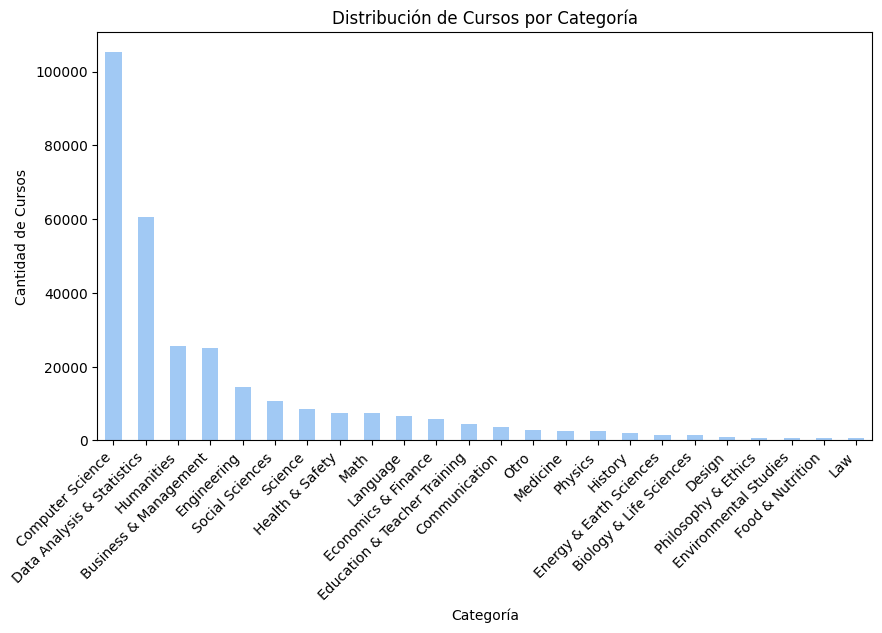

In [187]:
import matplotlib.pyplot as plt

# Obtener la cuenta de cursos por categoría
categoria_counts = df1['categoria'].value_counts()

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
categoria_counts.plot(kind='bar', ax=ax)
plt.title('Distribución de Cursos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Cursos')

# Establecer las etiquetas del eje x
plt.xticks(range(len(categoria_counts)), categoria_counts.index, rotation=45, ha='right')

# Ajustar los márgenes y el espaciado
plt.subplots_adjust(bottom=0.2)

# Mostrar el gráfico
plt.show()


Podemos observar que la mayor cantidad de cursos que se estan ofreciendo actualmente en la platadorma esta vinculaods al rubrode la tecnologia, seguidos por analisis de datos y economia.

<Figure size 1000x600 with 0 Axes>

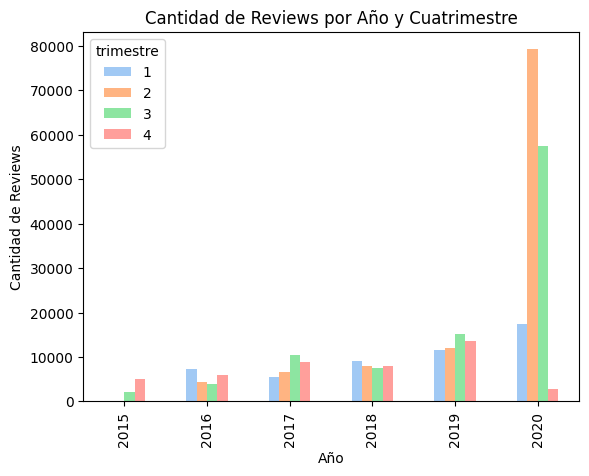

In [188]:
import matplotlib.pyplot as plt

# Agrupar los datos por año y cuatrimestre y contar la cantidad de reviews
reviews_por_cuatri = df1.groupby(['año', 'trimestre']).size().unstack()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
reviews_por_cuatri.plot(kind='bar')
plt.title('Cantidad de Reviews por Año y Cuatrimestre')
plt.xlabel('Año')
plt.ylabel('Cantidad de Reviews')

# Mostrar el gráfico
plt.show()


Observamos una tendencia de aumento del consumo de cursos, partiendo de la base que aumento la cantidad de personas que realizaron reviews apartir del segundo trimestre del año 2020. Lo cual es coincidente con meses posteriores a la declaracion de la pandemia. La cual se declaro el 21 de enero de 2020.

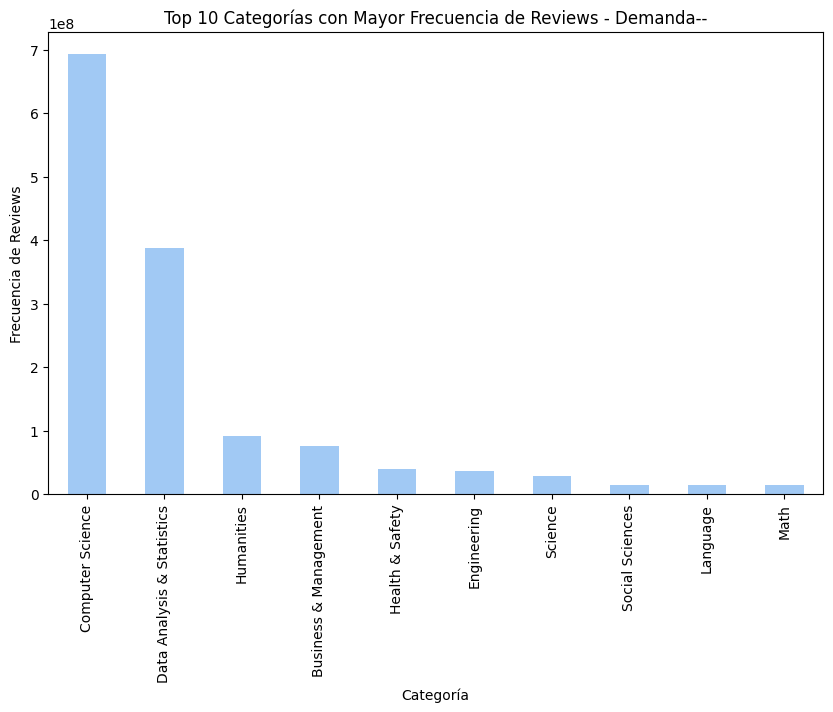

In [189]:
import matplotlib.pyplot as plt

# Obtener la frecuencia de reviews por categoría
frecuencia_reviews = df1.groupby('categoria')['cantidad_reviews'].sum().sort_values(ascending=False)

# Obtener las diez categorías con mayor frecuencia de reviews
top_10_categorias = frecuencia_reviews.head(10)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
top_10_categorias.plot(kind='bar')
plt.title('Top 10 Categorías con Mayor Frecuencia de Reviews - Demanda--')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia de Reviews')

# Mostrar el gráfico
plt.show()


Estudiamos la cantidad de Reviews que tienen las categorias de curso. Estudiar los reviews no es util si trabajamos con la hipotesis representa la demanda de tipos de cursos de nuestros clientes (estudiantes). Lo cual nos permite comparar entre la demanda y la oferta de cursos que tenemos a los efectos de aumentar la oferta de aquellos cursos que mas se demandan.

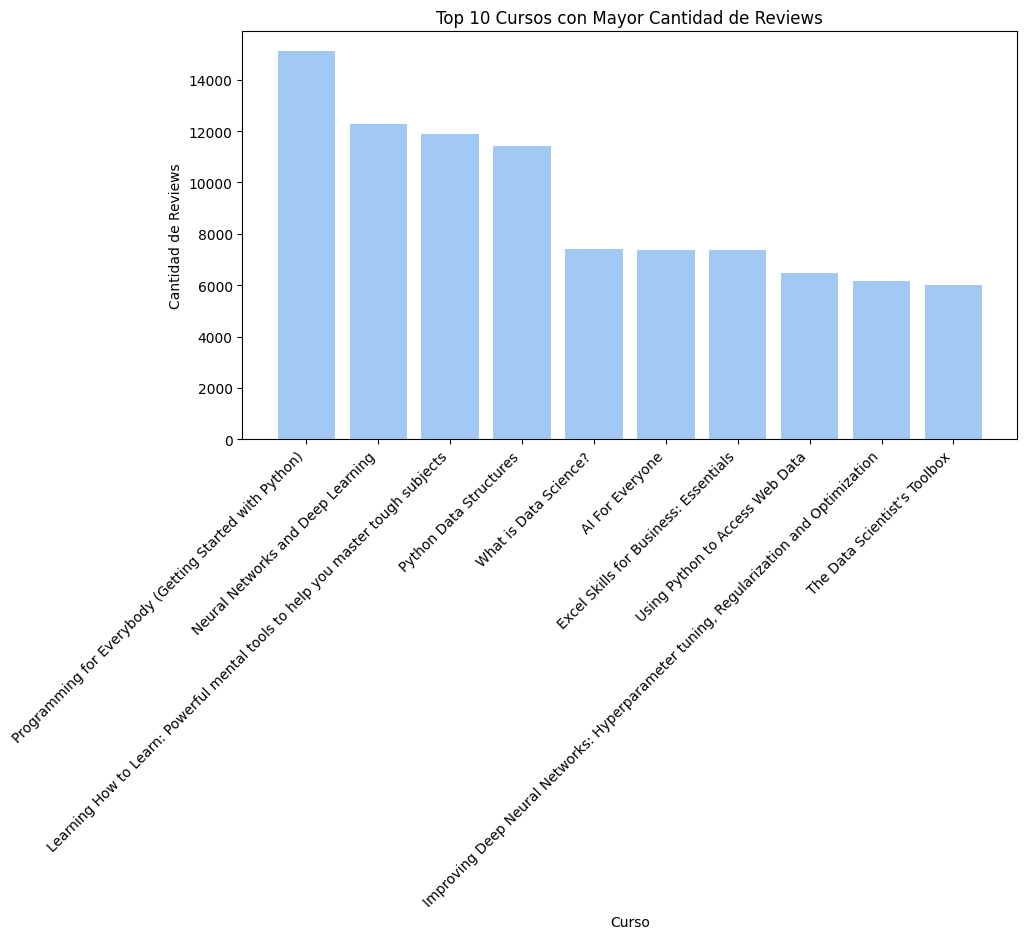

In [191]:
top_cursos = df1.drop_duplicates(subset='course_id').nlargest(10, 'cantidad_reviews')

plt.figure(figsize=(10, 6))
plt.bar(top_cursos['name'], top_cursos['cantidad_reviews'])
plt.title('Top 10 Cursos con Mayor Cantidad de Reviews')
plt.xlabel('Curso')
plt.ylabel('Cantidad de Reviews')
plt.xticks(rotation=45)

# Establecer las etiquetas del eje x
plt.xticks(range(len(top_cursos['name'])), top_cursos['name'], rotation=45, ha='right')

# Ajustar los márgenes y el espaciado
plt.subplots_adjust(bottom=0.2)

# Mostrar el gráfico
plt.show()


Observamos que los cursos con mayor cantidad de reviews pertenecen a la categoria Computer Science. Esto nos permite concluir que la categoria Computer Science es la categoria que mas demanda tiene.

Dado que carecemos de una columna de Demanda, vamos a buscar un promedio entre la columna "number review" de la empresa udemy y "num_subscribers" para sacar un promedio entre las personas que hacen un review respecto a los inscriptos por cursos. Lo anterior a los efectos de encontrar un promedio para acrecentar nuestro numero de reviews y encontrar un aproximado de la demanda. 

In [ ]:
df_udemy= pd.read_csv("udemy_courses.csv", sep=",", encoding = "utf-8")

In [ ]:
# Calcular la diferencia
df_udemy['difference'] = df_udemy['num_subscribers'] - df_udemy['num_reviews']

# Calcular el porcentaje
df_udemy['percentage difference'] = (df_udemy['difference'] / df_udemy['num_subscribers']) * 100

In [ ]:
percentage_difference = df_udemy['percentage difference'].mean()

In [ ]:
# Calcular el incremento porcentual utilizando la variación promedio
increment = df1['cantidad_reviews'] * (percentage_difference / 100)

In [ ]:
# Aumentar los valores de la demanda en función del incremento porcentual
df1['demanda2']= df1['cantidad_reviews'] + increment

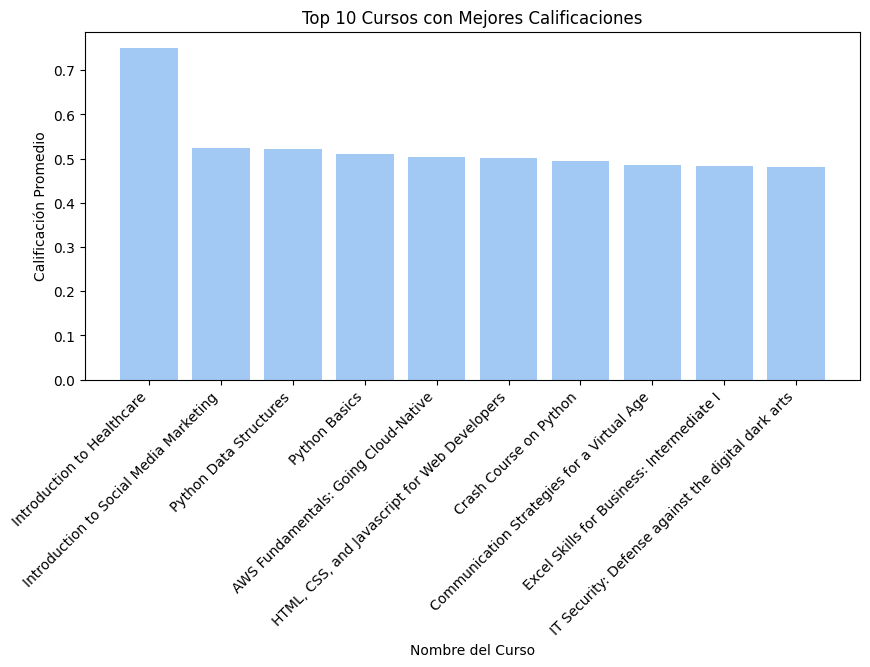

In [192]:
promedio_calificaciones = df1.groupby('name')['calificacion'].mean().reset_index()

top_calificaciones = promedio_calificaciones.nlargest(10, 'calificacion')

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_calificaciones['name'])), top_calificaciones['calificacion'])
plt.title('Top 10 Cursos con Mejores Calificaciones')
plt.xlabel('Nombre del Curso')
plt.ylabel('Calificación Promedio')
plt.xticks(range(len(top_calificaciones['name'])), top_calificaciones['name'], rotation=45, ha='right')

# Ajustar los márgenes y el espaciado
plt.subplots_adjust(bottom=0.3)

# Mostrar el gráfico
plt.show()




Dentro del ranking de mejores cursos calificados encontramos que de los 10 cursos 6 son del rubro tecnologia. Sin embargo, al poseer una amplio abanico de cursos de tecnologia, es más conveniente analizar por categoria.

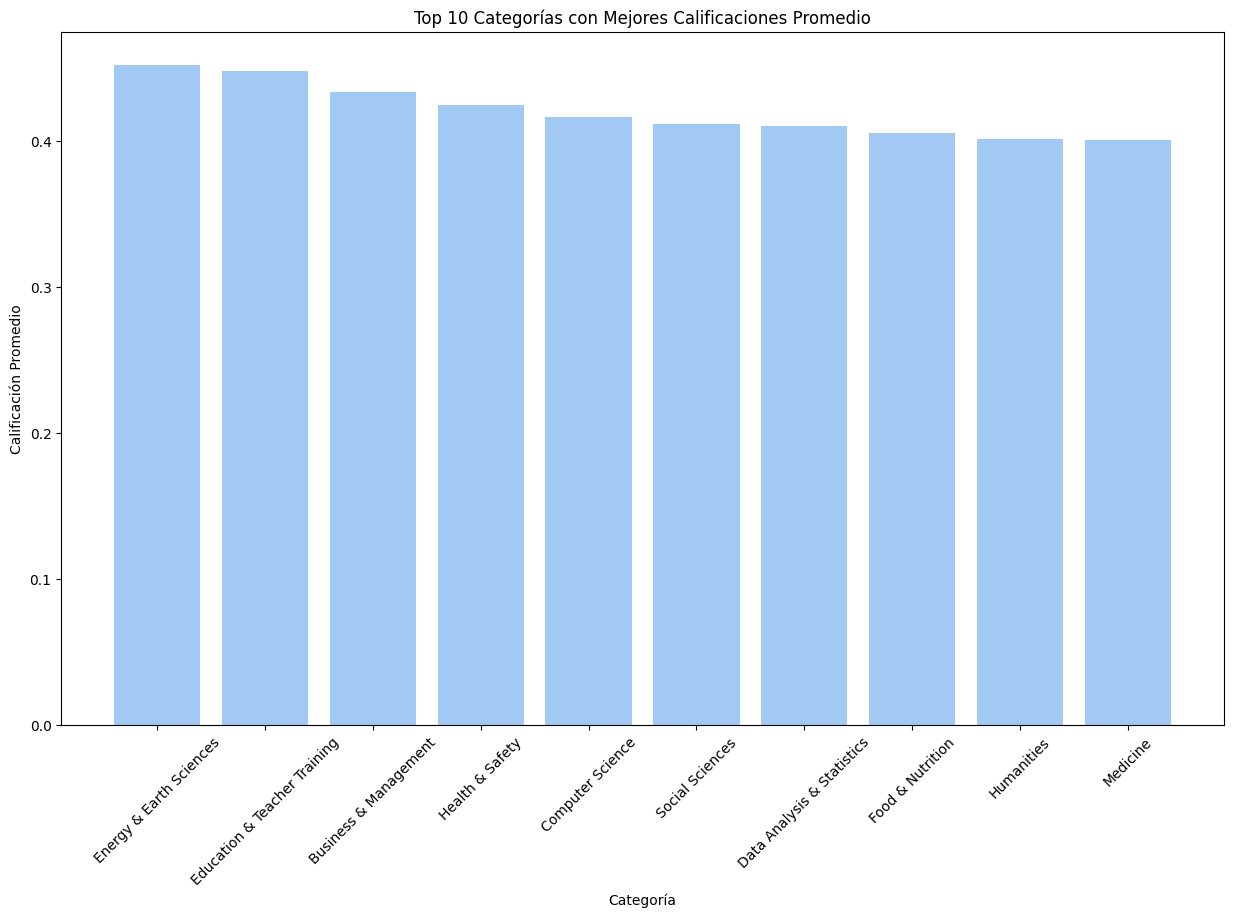

In [193]:
# Calcular la calificación promedio por categoría
promedio_calificaciones_categoria = df1.groupby('categoria')['calificacion'].mean()

# Obtener las top categorías con mejores calificaciones promedio
top_categorias_calificaciones = promedio_calificaciones_categoria.nlargest(10)

# Crear el gráfico de barras
plt.figure(figsize=(15, 9))
plt.bar(top_categorias_calificaciones.index, top_categorias_calificaciones.values)
plt.title('Top 10 Categorías con Mejores Calificaciones Promedio')
plt.xlabel('Categoría')
plt.ylabel('Calificación Promedio')
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()



Las mejores calificacion por categoria en base al analisis de los reviews nos demuestra que hay un campo de mejora en los cursos de tecnologia donde hay mayor demanda. Tal como se observa la categoria que posee mejores reviews es Filosofia y Etica la cual en nuestro analisis de demanda se encuentra por fuera de los tops 10 con menor demanda.

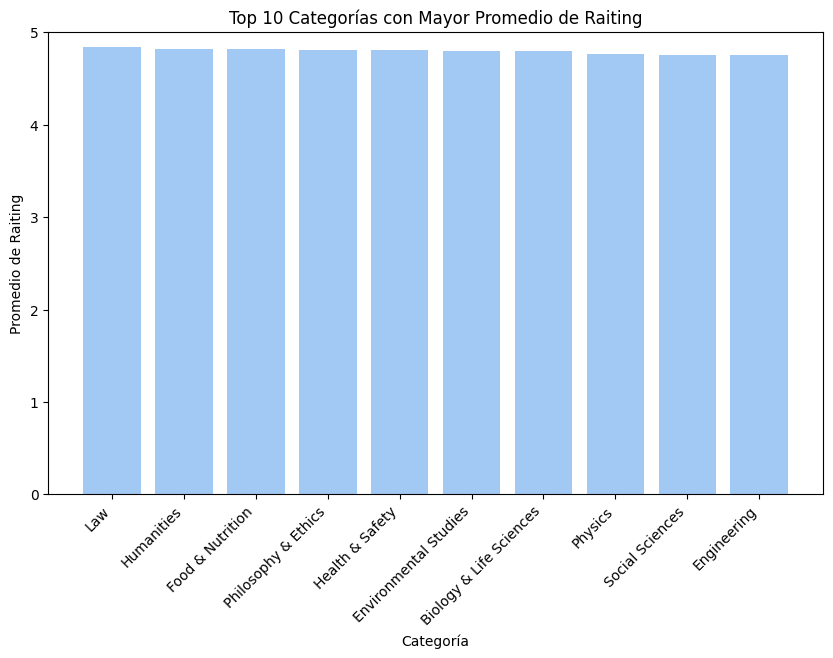

In [194]:
# Calcular el promedio de calificación por categoría
promedio_raiting_por_categoria = df1.groupby('categoria')['rating'].mean()

# Obtener las categorías con mayor promedio de calificaciones
top_categorias = promedio_raiting_por_categoria.nlargest(10)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(top_categorias.index, top_categorias.values)
plt.title('Top 10 Categorías con Mayor Promedio de Raiting')
plt.xlabel('Categoría')
plt.ylabel('Promedio de Raiting')
plt.ylim(0, 5)  # Establecer límites del eje y entre 0 y 5

# Ajustar las etiquetas del eje x
plt.xticks(range(len(top_categorias.index)), top_categorias.index, rotation=45, ha='right')

plt.show()

Observamos que el rating de los TOP 10 , que de las categorias mas demandadas no se encuentran. Lo cual fortalece la necesidad de mejorar la calidad de los cursos dado nuestros potenciales clientes no estan satifaciendo su necesidad correctamente.

In [195]:
df1.columns


Index(['rating', 'course_id', 'frecuencia_registros', 'cantidad_reviews',
       'calificacion', 'name', 'institution', 'trimestre', 'año', 'categoria'],
      dtype='object')

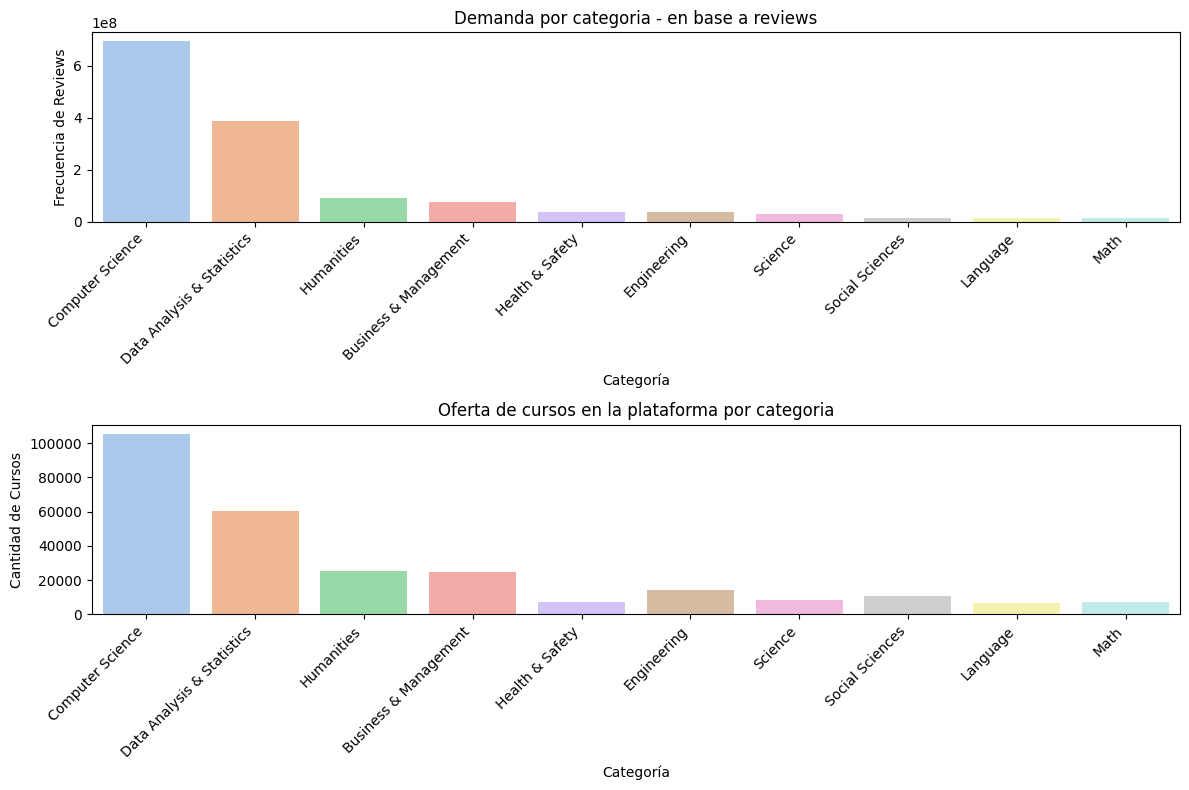

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la frecuencia de reviews por categoría
frecuencia_reviews = df1.groupby('categoria')['cantidad_reviews'].sum().sort_values(ascending=False)

# Obtener las diez categorías con mayor frecuencia de reviews
top_10_categorias = frecuencia_reviews.head(10)

# Obtener la cuenta de cursos por categoría
categoria_counts = df1['categoria'].value_counts().loc[top_10_categorias.index]

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Usar un esquema de colores de seaborn
sns.set_palette('pastel')

# Crear el gráfico de barras para la frecuencia de reviews
plt.subplot(2, 1, 1)
sns.barplot(x=top_10_categorias.index, y=top_10_categorias.values)
plt.title('Demanda por categoria - en base a reviews')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia de Reviews')

# Crear el gráfico de barras para la distribución de cursos
plt.subplot(2, 1, 2)
sns.barplot(x=categoria_counts.index, y=categoria_counts.values)
plt.title('Oferta de cursos en la plataforma por categoria')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Cursos')

# Ajustar las etiquetas del eje x
plt.subplot(2, 1, 1)
plt.xticks(rotation=45, ha='right')
plt.subplot(2, 1, 2)
plt.xticks(rotation=45, ha='right')

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()


De la comparacion de la oferta y la demanda podemo observar que tenemos un abanico para mejorar en las categorias Data Analysis & Statistics y Economics &Finance. Donde observamos mayor oferta que demanda.

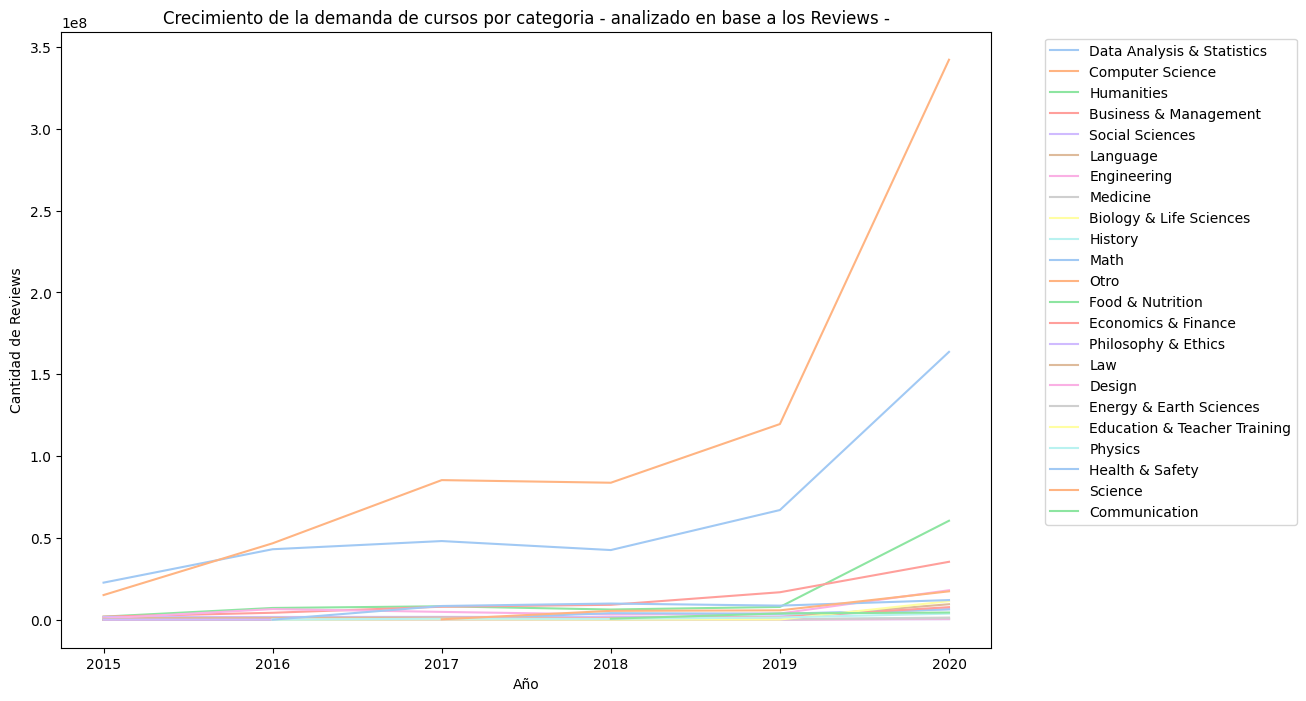

In [197]:
import matplotlib.pyplot as plt

# Agrupar los datos por categoría y año y calcular la suma de reviews
demand_growth = df1.groupby(['categoria', 'año'])['cantidad_reviews'].sum().reset_index()

# Ordenar los resultados en orden descendente por año y cantidad_reviews
demand_growth = demand_growth.sort_values(['año', 'cantidad_reviews'], ascending=[True, False])

# Seleccionar las 20 categorías principales por año
top_20_growth = demand_growth.groupby('año').head(20)

# Crear un gráfico de líneas para mostrar el crecimiento de las categorías principales a lo largo del tiempo
plt.figure(figsize=(12, 8))
for categoria in top_20_growth['categoria'].unique():
    data = top_20_growth[top_20_growth['categoria'] == categoria]
    plt.plot(data['año'], data['cantidad_reviews'], label=categoria)

plt.title('Crecimiento de la demanda de cursos por categoria - analizado en base a los Reviews -')
plt.xlabel('Año')
plt.ylabel('Cantidad de Reviews')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(top_20_growth['año'].unique())
plt.show()


Confirmamos que el curso que tiene mayor demanda es la categoria Data Analysis & Statistics. Pudiendo ver un punto de mejora en aumentar la oferta de este curso y tambien aumentar calidad de los mismos dado que se encuentran en el puesto decimo en la calificacion de reviews y no se encuentra en los top 10 de rating dada por el publico.

In [199]:
institucion_ratings = df1.groupby('institution')['calificacion'].mean()


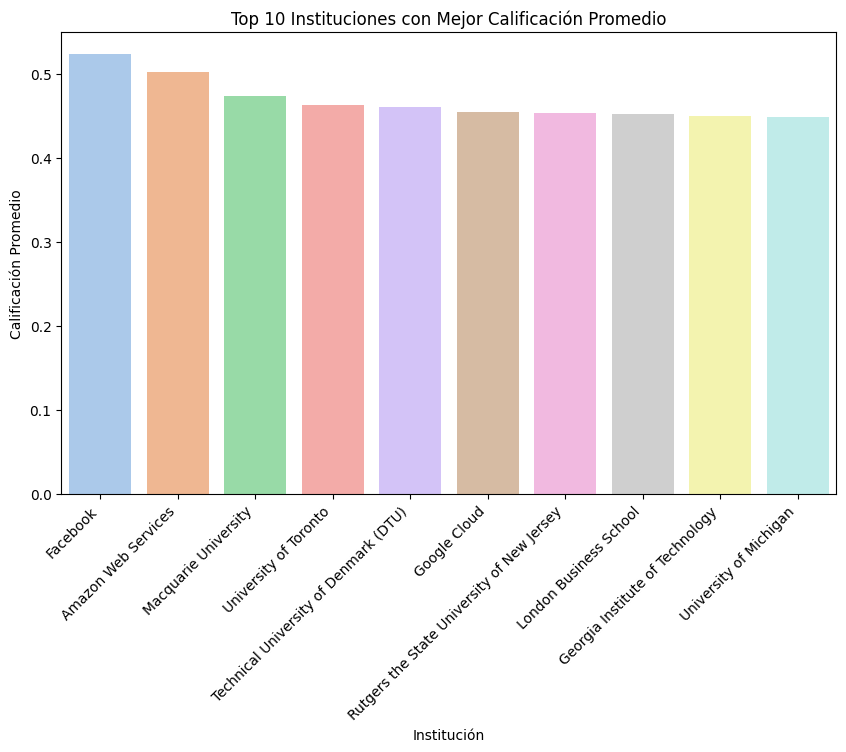

In [200]:
top_10_instituciones = institucion_ratings.nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_instituciones.index, y=top_10_instituciones.values)
plt.title('Top 10 Instituciones con Mejor Calificación Promedio')
plt.xlabel('Institución')
plt.ylabel('Calificación Promedio')
plt.xticks(rotation=45, ha='right')
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'University of Michigan'),
  Text(1, 0, 'DeepLearning.AI'),
  Text(2, 0, 'IBM'),
  Text(3, 0, 'Johns Hopkins University'),
  Text(4, 0, 'University of Pennsylvania'),
  Text(5, 0, 'Google'),
  Text(6, 0, 'University of California San Diego'),
  Text(7, 0, 'Stanford University'),
  Text(8, 0, 'Google Cloud'),
  Text(9, 0, 'Macquarie University')])

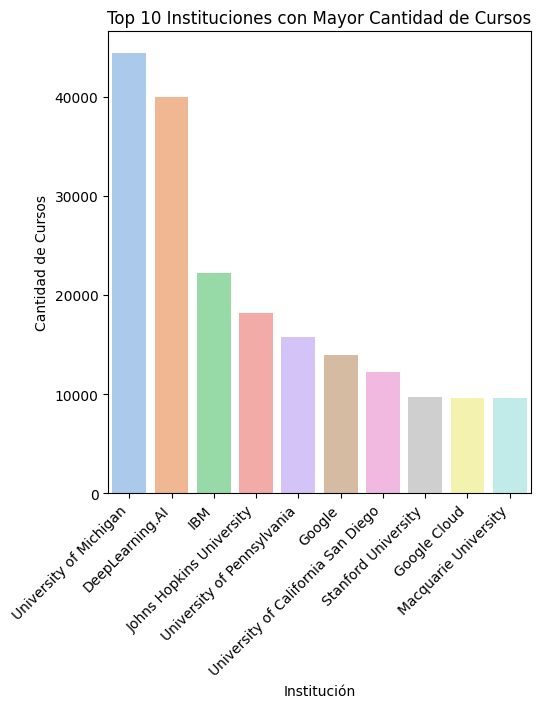

In [201]:
# Obtener la cuenta de cursos por institución
institucion_counts = df1['institution'].value_counts()

# Obtener las 10 instituciones con mayor cantidad de cursos
top_10_instituciones = institucion_counts.head(10)

# Obtener la distribución de cursos por categoría e institución para las 10 instituciones principales
categoria_institucion_counts = df1[df1['institution'].isin(top_10_instituciones.index)].groupby(['categoria', 'institution']).size().unstack(fill_value=0)

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crear el gráfico de barras para la cantidad de cursos por institución
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_instituciones.index, y=top_10_instituciones.values)
plt.title('Top 10 Instituciones con Mayor Cantidad de Cursos')
plt.xlabel('Institución')
plt.ylabel('Cantidad de Cursos')
plt.xticks(rotation=45, ha='right')

Si comparamos el ranking de las instituciones con mejores calificaciones y lo comparamos con los cursos que tenemos cargados en la plataforma. Observamos que no tenemos un numero considerable de cursos por las universidades con mayor calificacion por los usuarios

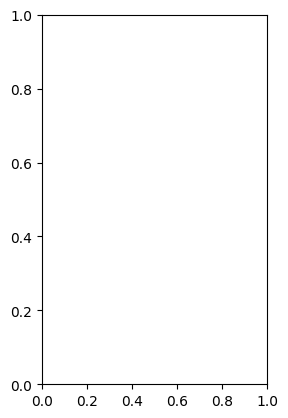

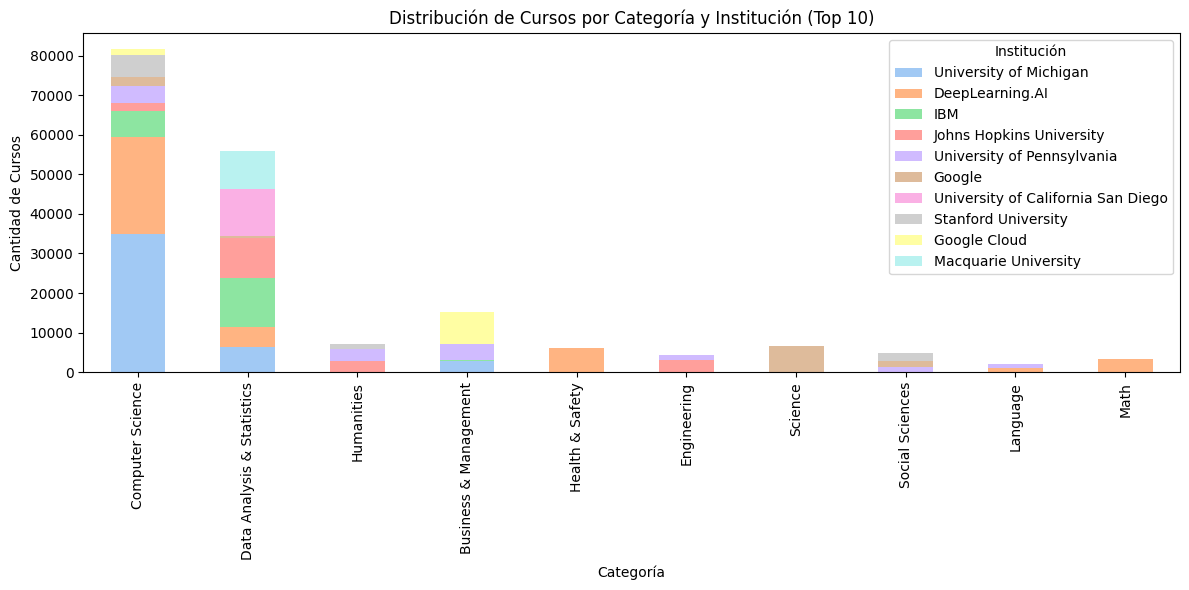

In [202]:
# Filtrar el DataFrame categoria_institucion_counts por las instituciones principales y las categorías más demandadas
categoria_institucion_counts_filtered = categoria_institucion_counts[top_10_instituciones.index].loc[top_10_categorias.index]

# Crear el gráfico de barras para la distribución de cursos por categoría e institución filtrado
plt.subplot(1, 2, 2)
categoria_institucion_counts_filtered.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribución de Cursos por Categoría y Institución (Top 10)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Cursos')
plt.legend(title='Institución', bbox_to_anchor=(1, 1))

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Si observamos la distribucion de los cursos mas demandados en relacion a las universidades que los brindan. Observamos que las universidades no se encuentran en top 10 con mayor ranking. Lo cual nos confirma en margen de mejora que tenemos en calidad de los cursos.

In [203]:
df1.columns

Index(['rating', 'course_id', 'frecuencia_registros', 'cantidad_reviews',
       'calificacion', 'name', 'institution', 'trimestre', 'año', 'categoria'],
      dtype='object')

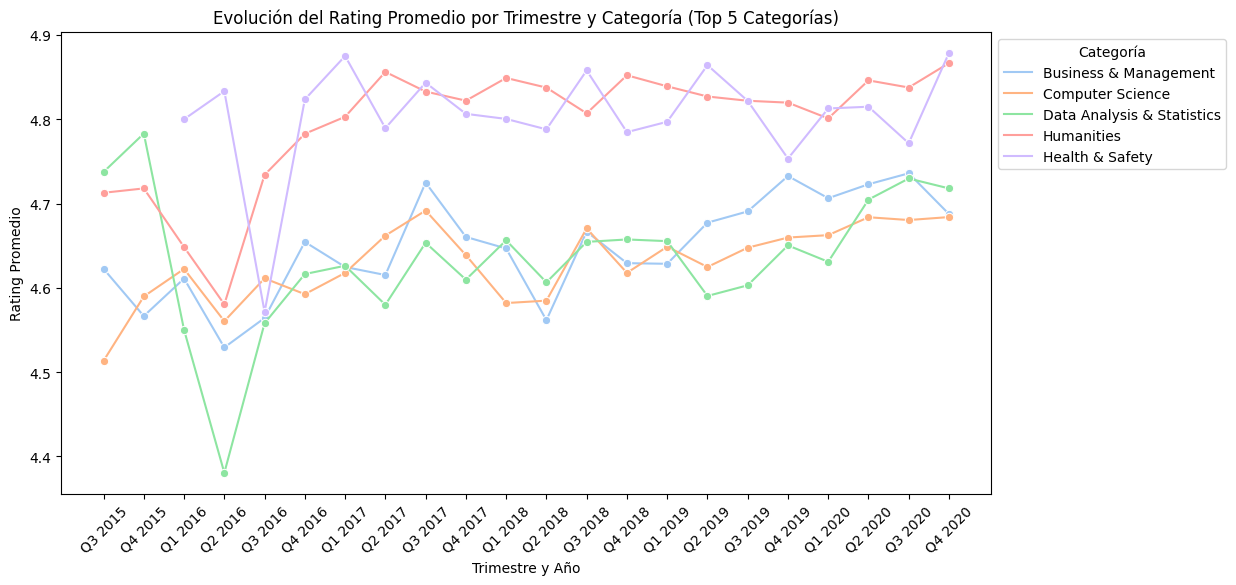

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar el DataFrame original por las 5 categorías más demandadas
top_5_categorias = top_10_categorias.head(5)
df_top_categorias = df1[df1['categoria'].isin(top_5_categorias.index)]

# Calcular el rating promedio por trimestre y año
rating_promedio_temporal = df_top_categorias.groupby(['año', 'trimestre', 'categoria'])['rating'].mean().reset_index()

# Transformar los valores del trimestre a formato de cadena (ejemplo: 'Q1 2022')
rating_promedio_temporal['trimestre'] = 'Q' + rating_promedio_temporal['trimestre'].astype(str) + ' ' + rating_promedio_temporal['año'].astype(str)

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crear el gráfico de líneas para la evolución del rating promedio por trimestre y categoría
sns.lineplot(data=rating_promedio_temporal, x='trimestre', y='rating', hue='categoria', marker='o')
plt.title('Evolución del Rating Promedio por Trimestre y Categoría (Top 5 Categorías)')
plt.xlabel('Trimestre y Año')
plt.ylabel('Rating Promedio')
plt.legend(title='Categoría', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

In [205]:
df_edx= pd.read_csv("edx_courses.csv", sep=",", encoding = "utf-8")

975 rows × 16 columns vs 974 rows × 16 columns

In [207]:
df_edx = df_edx.drop_duplicates()  #eliminamos columnas repetidas

In [208]:
# Obtener la cantidad de cursos ofertados en la plataforma
cantidad_cursos = len(df_edx['title'].unique())

print(cantidad_cursos)

972


In [209]:
#Eliminamos la columna course_url
df_edx.drop('course_url', axis=1, inplace=True)

In [210]:
#Eliminamos la columna course_description
df_edx.drop('course_description', axis=1, inplace=True)

In [211]:
#Eliminamos la columna course_syllabus
df_edx.drop('course_syllabus', axis=1, inplace=True)

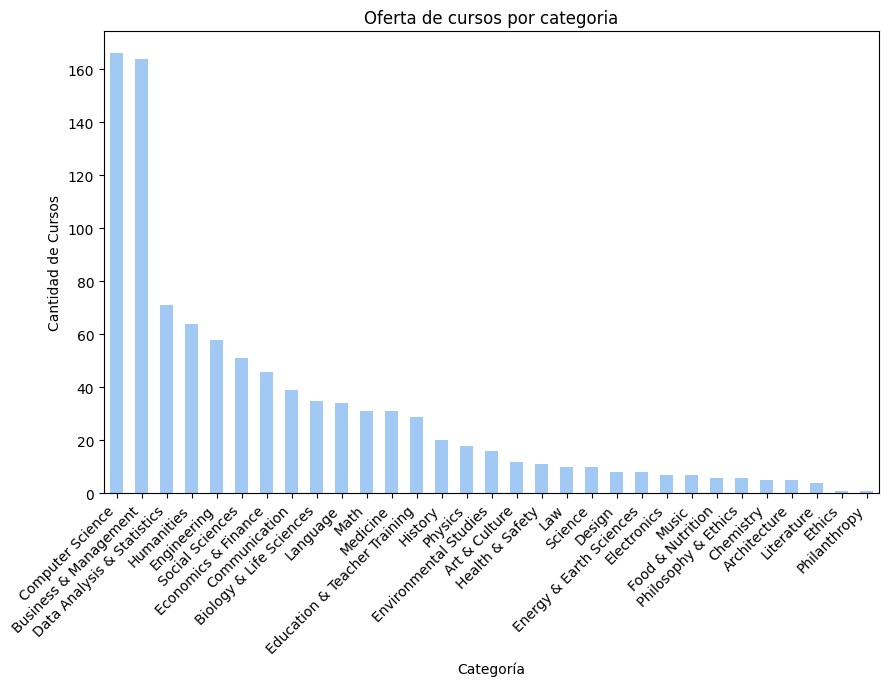

In [212]:
import matplotlib.pyplot as plt

# Obtener la cuenta de cursos por categoría (subject)
categoria_counts = df_edx['subject'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
categoria_counts.plot(kind='bar')
plt.title('Oferta de cursos por categoria')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Cursos')

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()


Eliminamos la coma de la columna de los inscriptos por cursos. Dado que asi podremos conocer la cantidad de inscriptos por curo o categoria. Consideramos que el numero estaba en miles, por eso eliminamos la coma.

In [213]:
# Eliminar las comas de la columna 'n_enrolled'
df_edx['n_enrolled'] = df_edx['n_enrolled'].str.replace(',', '')

# Convertir la columna 'n_enrolled' a tipo de datos numérico
df_edx['n_enrolled'] = df_edx['n_enrolled'].astype(float)

In [214]:
# Calcular el promedio por categoría y reemplazar los valores nulos
df_edx['n_enrolled'] = df_edx.groupby('subject')['n_enrolled'].transform(lambda x: x.fillna(x.mean()))

In [215]:
# Calcular la media y la desviación estándar por categoría
mean_by_category = df_edx.groupby('subject')['n_enrolled'].mean()
std_by_category = df_edx.groupby('subject')['n_enrolled'].std()

# Normalizar los valores utilizando z-score
df_edx['n_enrolled_normalized'] = df_edx.apply(lambda row: (row['n_enrolled'] - mean_by_category[row['subject']]) / std_by_category[row['subject']], axis=1)

In [216]:
import seaborn as sns

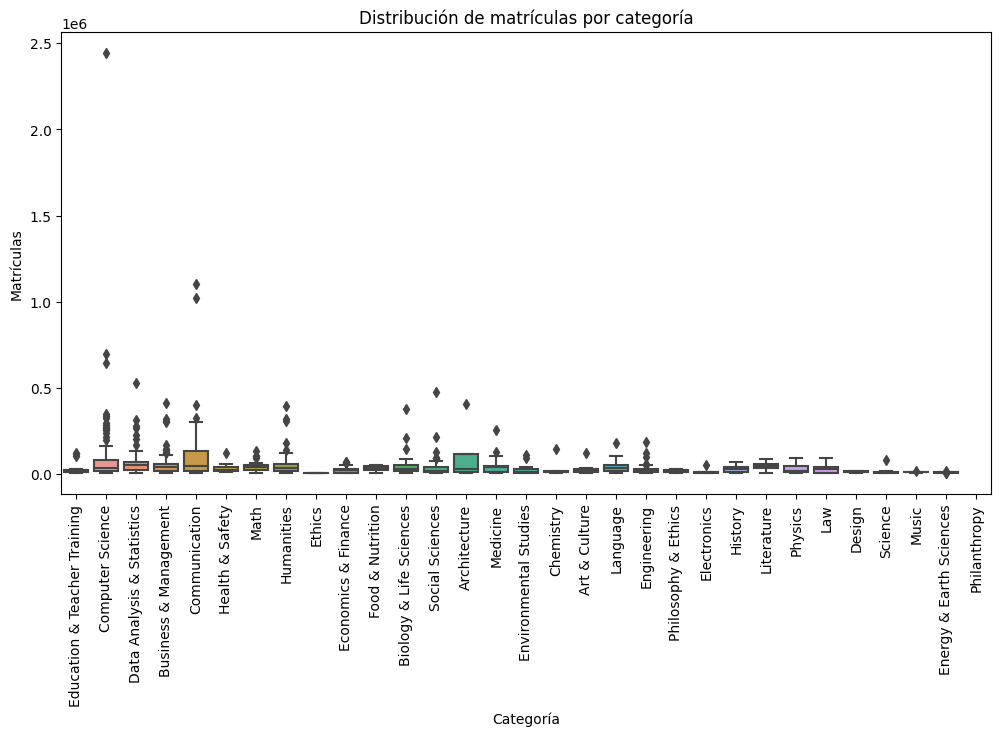

In [217]:
# Graficar la distribución por categoría
plt.figure(figsize=(12, 6))
sns.boxplot(x='subject', y='n_enrolled', data=df_edx)
plt.title('Distribución de matrículas por categoría')
plt.xlabel('Categoría')
plt.ylabel('Matrículas')
plt.xticks(rotation=90)
plt.show()

Observamos que hay algunos valores extremos por categoria.

In [218]:
# Calcular la media y la desviación estándar por categoría
mean_by_category = df_edx.groupby('subject')['n_enrolled'].mean()
std_by_category = df_edx.groupby('subject')['n_enrolled'].std()

# Normalizar los valores utilizando z-score
df_edx['n_enrolled_normalized'] = df_edx.apply(lambda row: (row['n_enrolled'] - mean_by_category[row['subject']]) / std_by_category[row['subject']], axis=1)

Normalizamos los valores de subject.

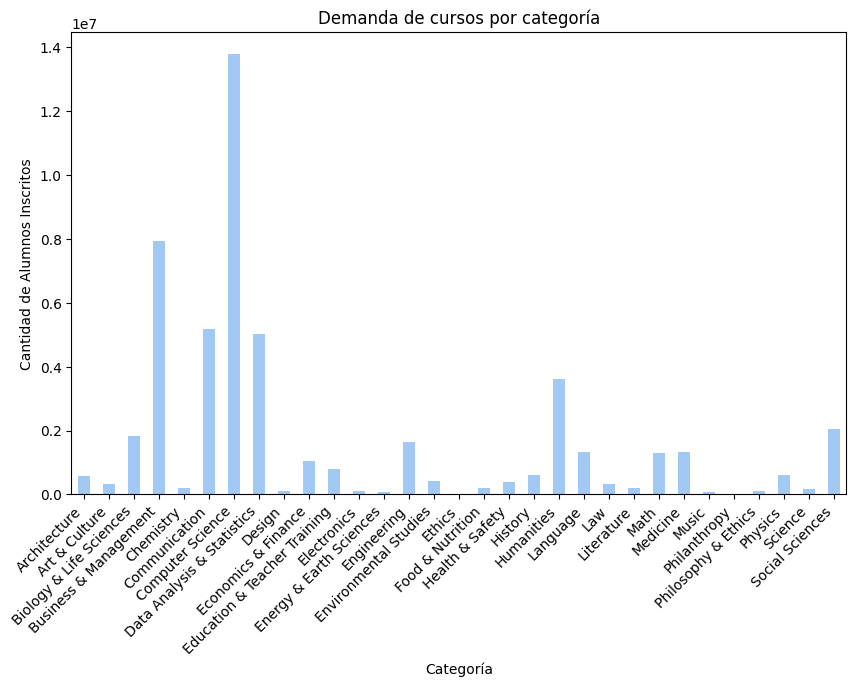

In [219]:
import matplotlib.pyplot as plt

# Calcular la suma de alumnos inscritos por categoría
categoria_enrollment = df_edx.groupby('subject')['n_enrolled'].sum()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
categoria_enrollment.plot(kind='bar')
plt.title('Demanda de cursos por categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Alumnos Inscritos')

# Ajustar las etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()


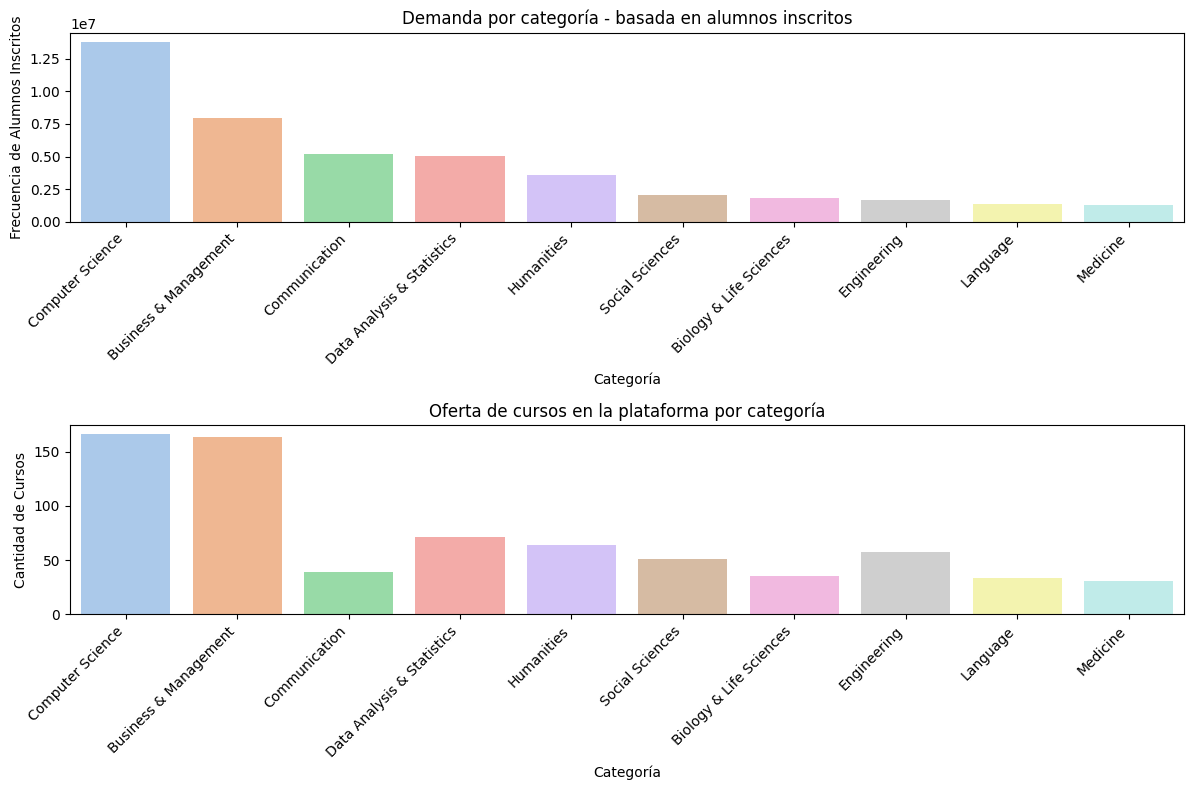

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la frecuencia de alumnos inscritos por categoría
frecuencia_enrollment = df_edx.groupby('subject')['n_enrolled'].sum().sort_values(ascending=False)

# Obtener las diez categorías con mayor frecuencia de alumnos inscritos
top_10_categorias = frecuencia_enrollment.head(10)

# Obtener la cuenta de cursos por categoría
categoria_counts = df_edx['subject'].value_counts().loc[top_10_categorias.index]

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Usar un esquema de colores de seaborn
sns.set_palette('pastel')

# Crear el gráfico de barras para la frecuencia de alumnos inscritos
plt.subplot(2, 1, 1)
sns.barplot(x=top_10_categorias.index, y=top_10_categorias.values)
plt.title('Demanda por categoría - basada en alumnos inscritos')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia de Alumnos Inscritos')

# Crear el gráfico de barras para la distribución de cursos
plt.subplot(2, 1, 2)
sns.barplot(x=categoria_counts.index, y=categoria_counts.values)
plt.title('Oferta de cursos en la plataforma por categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Cursos')

# Ajustar las etiquetas del eje x
plt.subplot(2, 1, 1)
plt.xticks(rotation=45, ha='right')
plt.subplot(2, 1, 2)
plt.xticks(rotation=45, ha='right')

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Ademas de observar que los cursos mas demandados coincide con los cursos de la empresa coursera. Podemos observar que en este caso la oferta de cursos ofrecida por el competidor edx responde a la demanda actual de alumnos. Encontrando una diferencia en terminos de la categoria comunicacion

In [221]:
price_type = df_edx['price'].dtype
print(price_type)


object


In [222]:
# Crear una nueva columna "price_text" con el texto del precio extraído
df_edx['price_text'] = df_edx['price'].str.extract(r'([A-Za-z\s]+)')

# Crear una nueva columna "price_value" con el valor numérico del precio extraído
df_edx['price_value'] = df_edx['price'].str.extract(r'([\d.]+)').astype(float)

In [223]:
# Identificar los valores únicos de la columna 'n_enrolled'
valores_unicos = df_edx['price_text'].unique()

# Imprimir los valores únicos
print(valores_unicos)

['FREE']


Controlamos los valores unicos de la columna que creamos con variable price_text. Y confirmamos que todos los cursos son FREE y que para tener la certificacion debes abonar un precio.

Vamos a estudiar algunas variables para conocer si existe una relacion de dependencia entre ellas y el numero de inscriptos en los cursos.

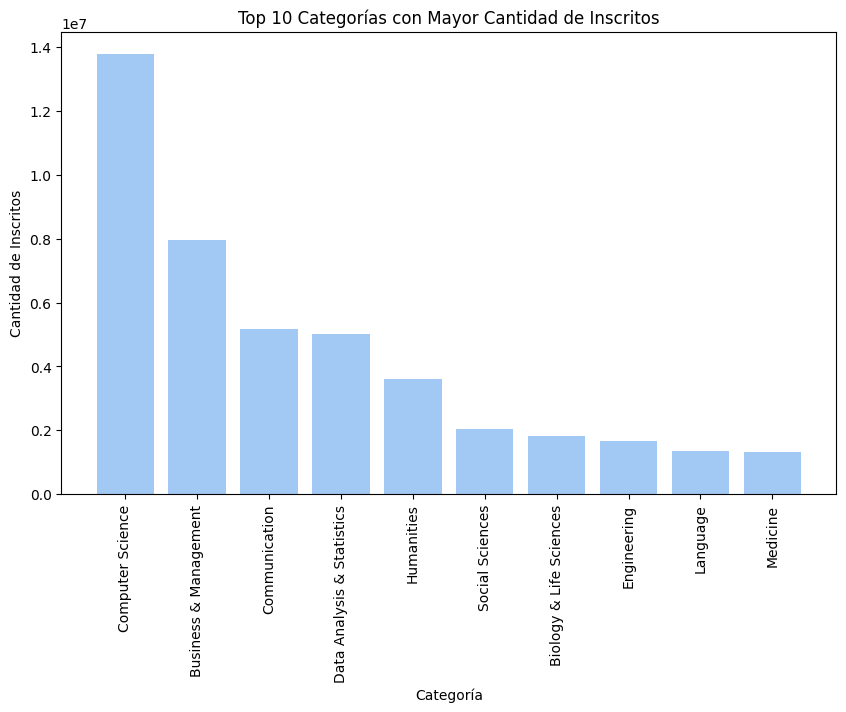

In [224]:
import matplotlib.pyplot as plt

# Calcular la suma de inscritos por categoría
inscritos_por_categoria = df_edx.groupby('subject')['n_enrolled'].sum()

# Ordenar las categorías por cantidad de inscritos de forma descendente
top_categorias_inscritos = inscritos_por_categoria.nlargest(10)

# Obtener los nombres de las categorías
nombres_categorias = top_categorias_inscritos.index

# Obtener la cantidad de inscritos
cantidad_inscritos = top_categorias_inscritos.values

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(nombres_categorias)), cantidad_inscritos)

# Configurar el título y los ejes
plt.title('Top 10 Categorías con Mayor Cantidad de Inscritos')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Inscritos')

# Ajustar el eje x para alinear correctamente las etiquetas
plt.xticks(range(len(nombres_categorias)), nombres_categorias, rotation=90)

# Mostrar el gráfico de barras
plt.show()


Observamos que la mayor cantidad de alumnos se inscriben a los cursos de la categoria Computer Science , Business & Management.

---



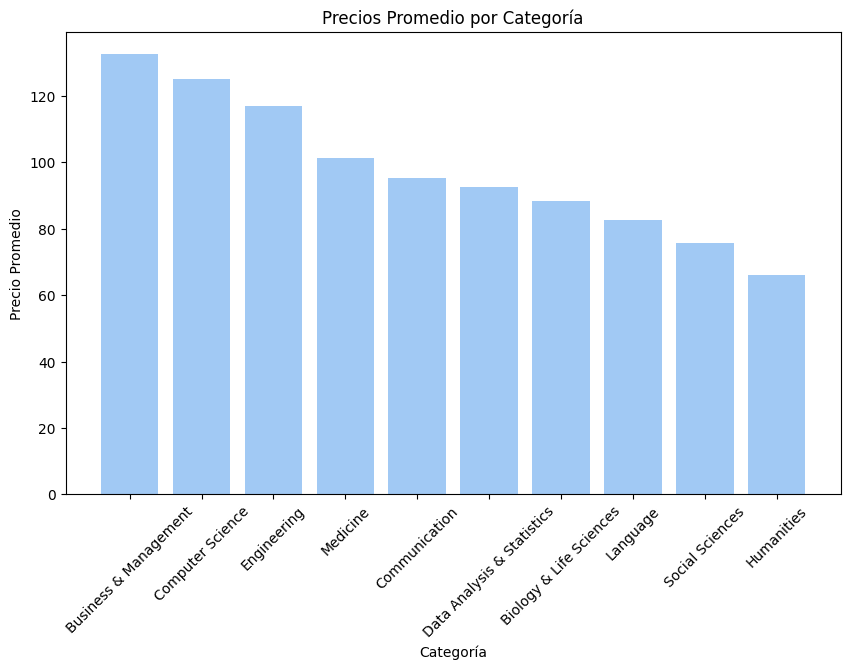

In [225]:
import matplotlib.pyplot as plt

# Obtener las top 10 categorías más demandadas
top_10_categorias = frecuencia_enrollment.head(10).index

# Filtrar el DataFrame original por las top 10 categorías
df_top_10_categorias = df_edx[df_edx['subject'].isin(top_10_categorias)]

# Calcular el precio promedio por categoría y ordenar en orden descendente
mean_price_by_category = df_top_10_categorias.groupby('subject')['price_value'].mean().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_price_by_category)), mean_price_by_category)

# Configurar el título y los ejes
plt.title('Precios Promedio por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Precio Promedio')

# Ajustar el eje x para alinear correctamente las etiquetas
plt.xticks(range(len(mean_price_by_category)), mean_price_by_category.index, rotation=45)

# Mostrar el gráfico de barras
plt.show()



Observamos que la categorias de los cursos con precios mas altos para obtener una certificacion concuerda con el top 3 de mayor cantidad de inscriptos. Esto es positivo en terminos de rentabilidad dado que observamos una tendencia de aumentar nuestra monetización.

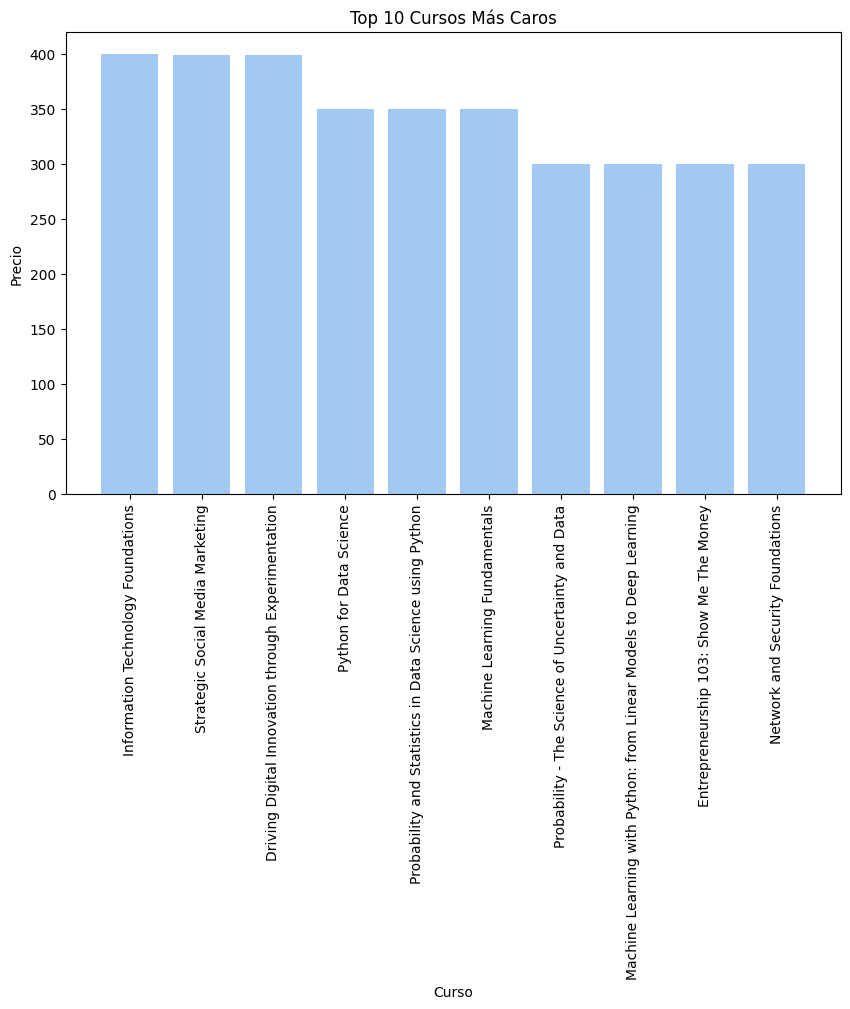

In [226]:
import matplotlib.pyplot as plt

# Filtrar el DataFrame por los cursos de las top 10 categorías
df_top_10_cursos = df_edx[df_edx['subject'].isin(top_10_categorias)]

# Ordenar los cursos por precio de forma descendente y tomar los 10 más caros
top_10_cursos_caros = df_top_10_cursos.nlargest(10, 'price_value')

# Obtener los precios de los cursos
precios_cursos = top_10_cursos_caros['price_value']

# Obtener los nombres de los cursos
nombres_cursos = top_10_cursos_caros['title']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(precios_cursos)), precios_cursos)

# Configurar el título y los ejes
plt.title('Top 10 Cursos Más Caros')
plt.xlabel('Curso')
plt.ylabel('Precio')

# Ajustar el eje x para alinear correctamente las etiquetas
plt.xticks(range(len(precios_cursos)), nombres_cursos, rotation=90)

# Mostrar el gráfico de barras
plt.show()

Validamos que los cursos de forma discrinado y no dentro de su categoria en su mayoria son del rubro de Data Science. Categoria ubicada en la posicion 2 en numero de inscripto como mas oneroso.

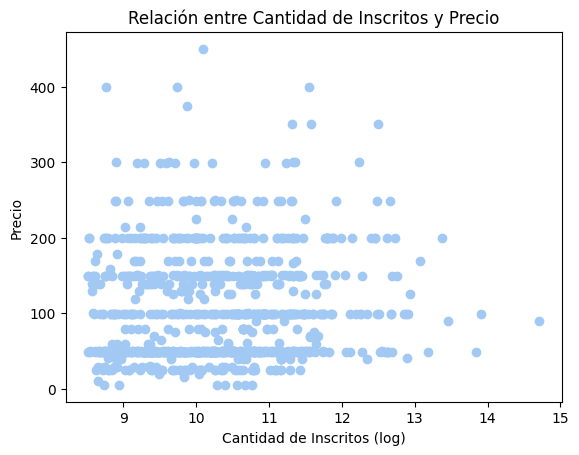

In [227]:
import numpy as np
import matplotlib.pyplot as plt

# Aplicar transformación logarítmica a la columna "n_enrolled" - buscamos eliminar valores extremos en las inscripciones-
log_enrolled = np.log1p(df_edx['n_enrolled'])

# Crear el gráfico de dispersión
plt.scatter(log_enrolled, df_edx['price_value'])

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscritos y Precio')
plt.xlabel('Cantidad de Inscritos (log)')
plt.ylabel('Precio')

# Mostrar el gráfico
plt.show()


No observamos una correlacion indirecta o directa entre la cantidad de inscriptos en base al precio. Lo cual nos permite validar que tenemos margen para aumentar los precios de las certificaciones de los cursos dado que no reducen la inscripcion por parte de alumnos.

In [228]:
grouped_df = df_edx.groupby('course_type')['n_enrolled'].sum().reset_index()


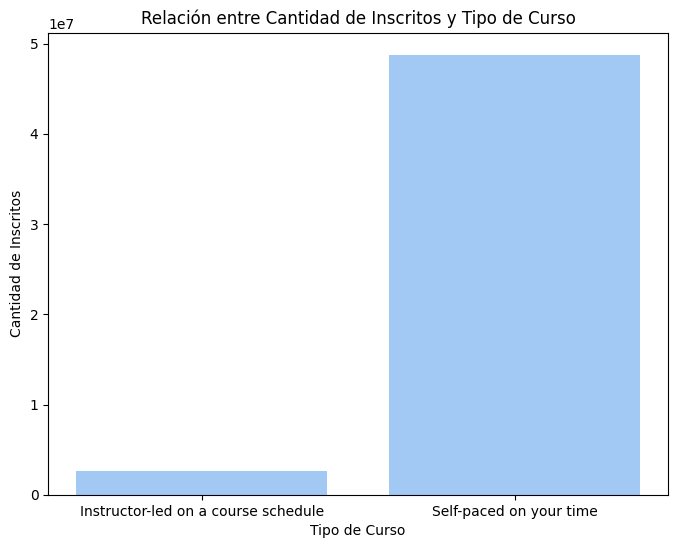

In [229]:
plt.figure(figsize=(8, 6))
plt.bar(grouped_df['course_type'], grouped_df['n_enrolled'])

plt.title('Relación entre Cantidad de Inscritos y Tipo de Curso')
plt.xlabel('Tipo de Curso')
plt.ylabel('Cantidad de Inscritos')

plt.show()


Observamos que la modalidad elegida por el estudiante es asincronico. Es decir aquella que le permita estudiar de forma ondemand.


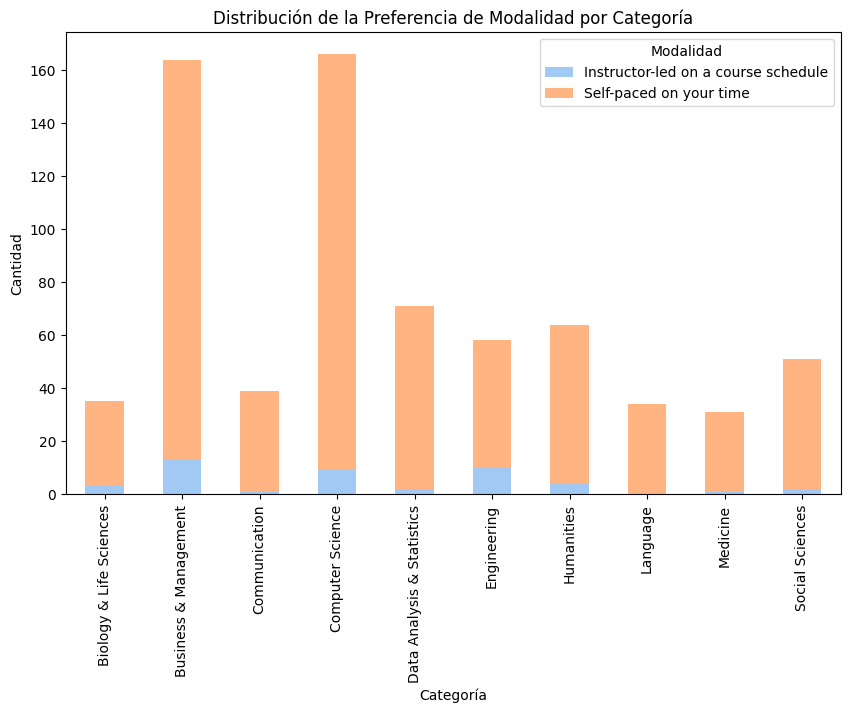

In [230]:
import matplotlib.pyplot as plt

# Calcular la suma de inscritos por categoría
inscritos_por_categoria = df_edx.groupby('subject')['n_enrolled'].sum()

# Ordenar las categorías por cantidad de inscritos de forma descendente
top_categorias_inscritos = inscritos_por_categoria.nlargest(10)

# Filtrar el DataFrame por las categorías con mayor cantidad de inscritos
df_top_categorias = df_edx[df_edx['subject'].isin(top_categorias_inscritos.index)]

# Calcular la distribución de la preferencia de modalidad por categoría
modalidad_por_categoria = df_top_categorias.groupby(['subject', 'course_type']).size().unstack()

# Crear un gráfico de barras apiladas
modalidad_por_categoria.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y los ejes
plt.title('Distribución de la Preferencia de Modalidad por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar la leyenda
plt.legend(title='Modalidad')

# Mostrar el gráfico
plt.show()


Observamos que la preferencia de tener clases on demand se mantiene independientemente de la categoria de curso en la que nos encontremos.

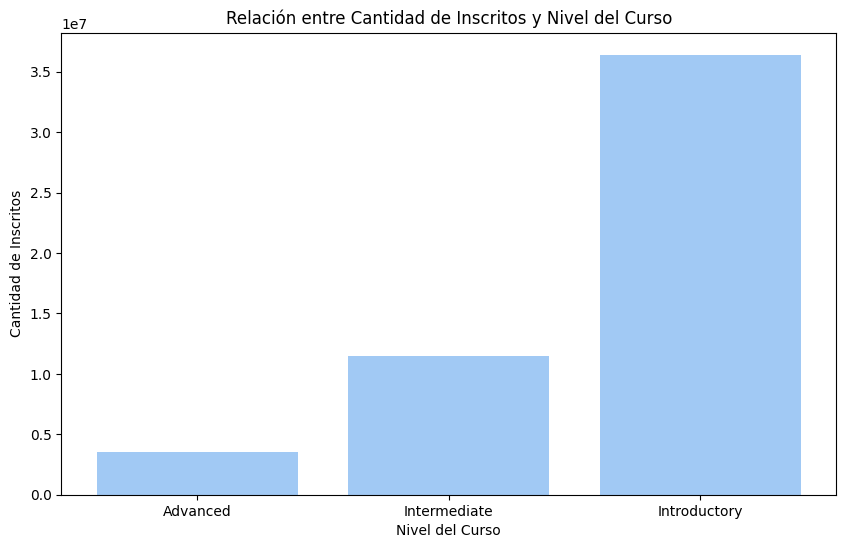

In [231]:
# Calcular la suma de inscritos por nivel
inscritos_por_nivel = df_edx.groupby('Level')['n_enrolled'].sum()

# Obtener los nombres de los niveles
niveles = inscritos_por_nivel.index

# Obtener la cantidad de inscritos por nivel
cantidad_inscritos = inscritos_por_nivel.values

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(niveles, cantidad_inscritos)

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscritos y Nivel del Curso')
plt.xlabel('Nivel del Curso')
plt.ylabel('Cantidad de Inscritos')

# Mostrar el gráfico de barras
plt.show()


Observamos que los cursos que tenemos mayor cantidad de inscriptos son los cursos introductorios seguido por el nivel intermedio. El nivel Advanced es la modalidad con l menor número de inscriptos.

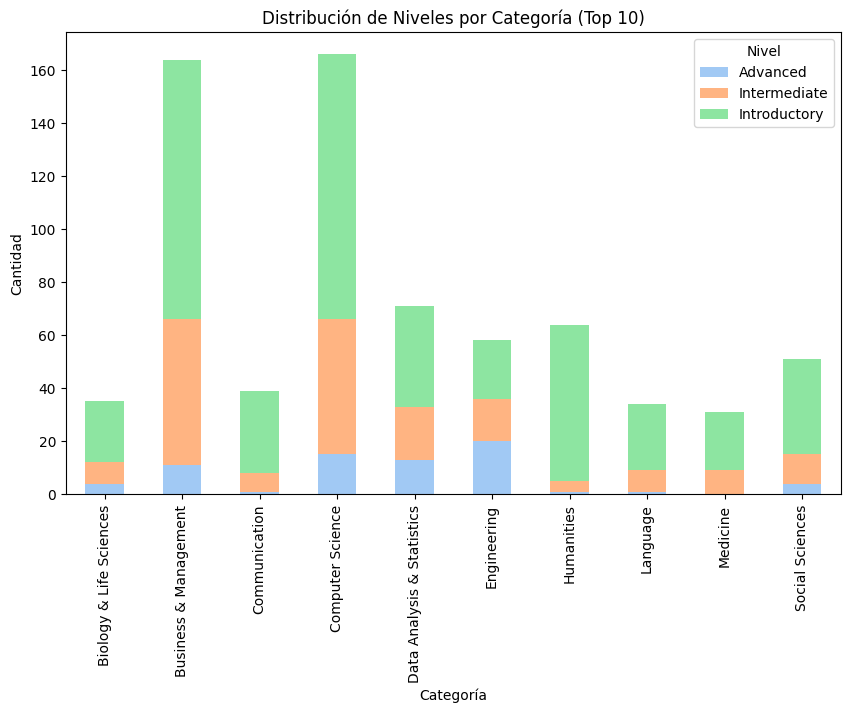

In [232]:
# Filtrar el DataFrame por las categorías con mayor cantidad de inscritos
df_top_categorias = df_edx[df_edx['subject'].isin(top_categorias_inscritos.index)]

# Calcular la distribución de los niveles por categoría
nivel_por_categoria = df_top_categorias.groupby(['subject', 'Level']).size().unstack()

# Crear un gráfico de barras apiladas
nivel_por_categoria.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y los ejes
plt.title('Distribución de Niveles por Categoría (Top 10)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar la leyenda
plt.legend(title='Nivel')

# Mostrar el gráfico
plt.show()


Observamos que si bien se mantiene la preferencia de los cursos introductorios en la mayorias de las categorias. Observamos que la categorias Engineering, Computer Science, y Data Analysus & Statistics posee un nivel alto de inscriptos de los cursos avanzados, a diferencia de las otras categorias.

df_edx.columns Index(['title', 'summary', 'n_enrolled',  'institution', 'language', 'subtitles', 'course_effort', 'course_length'], dtype='object')

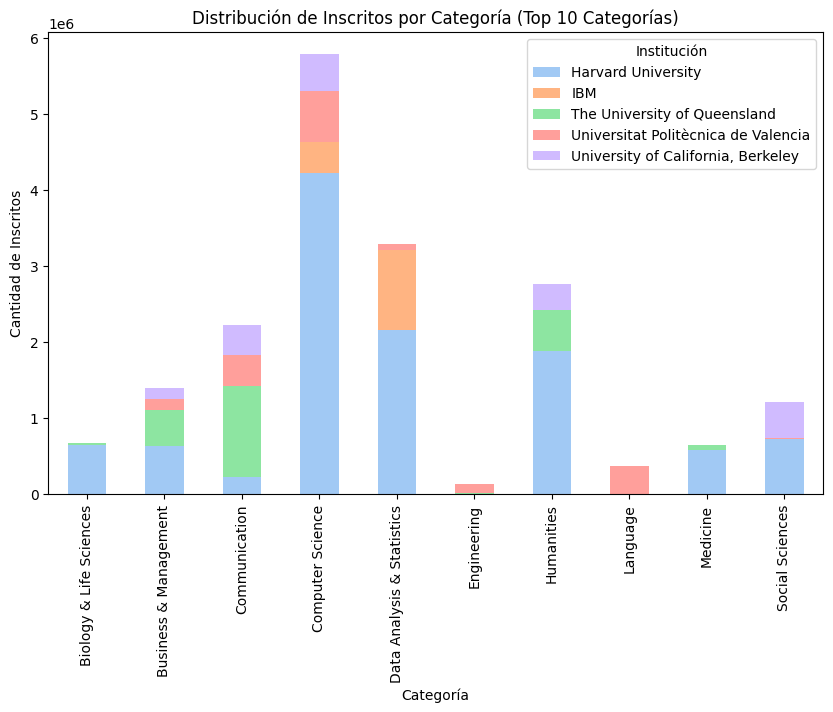

In [233]:
# Obtener las 10 categorías con mayor número de inscritos
top_10_categorias = df_edx.groupby('subject')['n_enrolled'].sum().nlargest(10).index

# Filtrar el DataFrame por las categorías con mayor número de inscritos
df_top_categorias = df_edx[df_edx['subject'].isin(top_10_categorias)]

# Obtener las 5 instituciones con mayor número de inscritos
top_5_instituciones = df_top_categorias.groupby('institution')['n_enrolled'].sum().nlargest(5).index

# Filtrar el DataFrame por las instituciones con mayor número de inscritos
df_top_instituciones = df_top_categorias[df_top_categorias['institution'].isin(top_5_instituciones)]

# Calcular la distribución de inscritos por categoría e institución
inscritos_por_categoria_institucion = df_top_instituciones.groupby(['subject', 'institution'])['n_enrolled'].sum().unstack()

# Crear un gráfico de barras apiladas
inscritos_por_categoria_institucion.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y los ejes
plt.title('Distribución de Inscritos por Categoría (Top 10 Categorías)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Inscritos')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar la leyenda
plt.legend(title='Institución')

# Mostrar el gráfico
plt.show()


Observamos que en las categorias con mayor numero de inscriptos existe una participación equitativa de uversidades o instituciones. Sin embargo, observamos que en 7 de las 10 categorias más votadas hay una preponderancia de la universidad de Harvard.

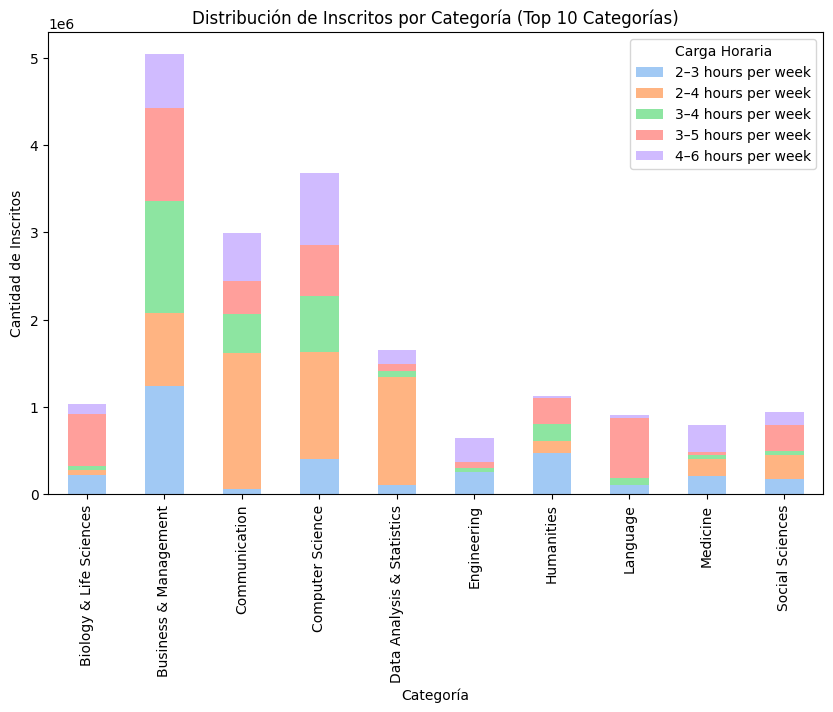

In [238]:
import matplotlib.pyplot as plt

# Obtener las 10 categorías con mayor número de inscritos
top_10_categorias = df_edx.groupby('subject')['n_enrolled'].sum().nlargest(10).index

# Filtrar el DataFrame por las categorías con mayor número de inscritos
df_top_categorias = df_edx[df_edx['subject'].isin(top_10_categorias)]

# Obtener las 5 cargas horarias con mayor número de inscritos
top_5_carga_horaria = df_top_categorias.groupby('course_effort')['n_enrolled'].sum().nlargest(5).index

# Filtrar el DataFrame por las cargas horarias con mayor número de inscritos
df_top_carga_horaria = df_top_categorias[df_top_categorias['course_effort'].isin(top_5_carga_horaria)]

# Calcular la distribución de inscritos por categoría y carga horaria
inscritos_por_categoria_carga_horaria = df_top_carga_horaria.groupby(['subject', 'course_effort'])['n_enrolled'].sum().unstack()

# Crear un gráfico de barras apiladas
inscritos_por_categoria_carga_horaria.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y los ejes
plt.title('Distribución de Inscritos por Categoría (Top 10 Categorías)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Inscritos')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar la leyenda
plt.legend(title='Carga Horaria')

# Mostrar el gráfico
plt.show()


De la distribución de carga horaria por categoria de curso no observamos un comportamiento uniforme. Se destaca de forma clara que la categoria de Computer Science posee una amplia cantidad de inscriptos en cursos donde la carga horaria por semana es la más alta (6 - 8 por semana) . Dicho comportamiento no se observa en el resto de las categorias donde se prefiere un esfuerzo menor.

In [239]:
inscritos_por_categoria_carga_horaria

course_effort               2–3 hours per week  2–4 hours per week  \
subject                                                              
Biology & Life Sciences           2.148570e+05        6.414200e+04   
Business & Management             1.244121e+06        8.289982e+05   
Communication                     5.679600e+04        1.562222e+06   
Computer Science                  4.001199e+05        1.233588e+06   
Data Analysis & Statistics        1.048740e+05        1.232393e+06   
Engineering                       2.497360e+05                 NaN   
Humanities                        4.671200e+05        1.438470e+05   
Language                          1.061390e+05                 NaN   
Medicine                          2.076835e+05        1.904073e+05   
Social Sciences                   1.692162e+05        2.771280e+05   

course_effort               3–4 hours per week  3–5 hours per week  \
subject                                                              
Biology & Life Sciences           4.931900e+04        5.876730e+05   
Business & Management             1.287612e+06        1.068993e+06   
Communication                     4.422050e+05        3.854580e+05   
Computer Science                  6.359510e+05        5.903390e+05   
Data Analysis & Statistics        6.899300e+04        8.105100e+04   
Engineering                       4.642200e+04        7.310784e+04   
Humanities                        1.991874e+05        2.938860e+05   
Language                          7.447489e+04        6.882536e+05   
Medicine                          5.535126e+04        2.642700e+04   
Social Sciences                   5.330800e+04        2.929992e+05   

course_effort               4–6 hours per week  
subject                                         
Biology & Life Sciences          114436.000000  
Business & Management            611169.828767  
Communication                    547124.371429  
Computer Science                 817937.000000  
Data Analysis & Statistics       161903.169492  
Engineering                      276554.918367  
Humanities                        23412.000000  
Language                          39379.888889  
Medicine                         312766.260870  
Social Sciences                  150381.195652

In [240]:
# Eliminar la palabra "weeks" y espacios adicionales
df_edx['course_length'] = df_edx['course_length'].str.replace('Weeks', '').str.strip()


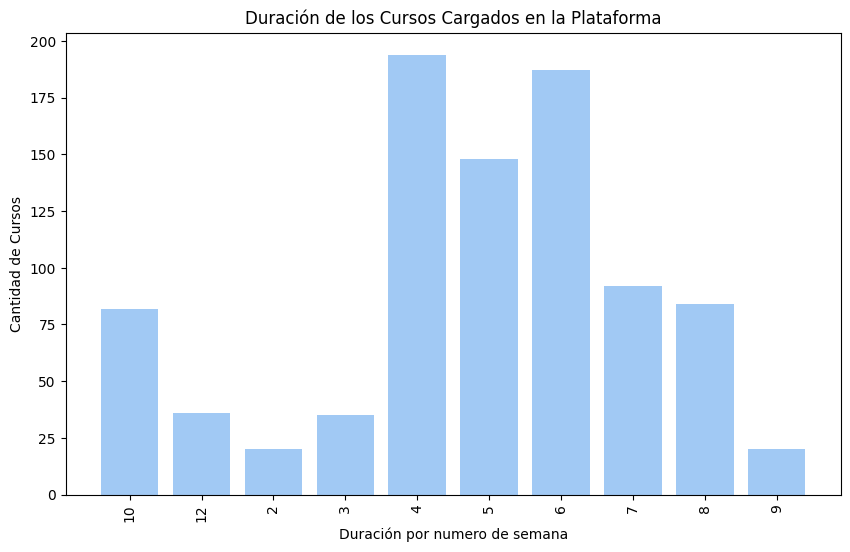

In [241]:
# Obtener las 5 duraciones más comunes de los cursos cargados en el sistema
top_5_duration = df_edx['course_length'].value_counts().nlargest(10).index

# Filtrar el DataFrame por las duraciones más comunes
df_top_duration = df_edx[df_edx['course_length'].isin(top_5_duration)]

# Calcular la distribución de duración por curso
duracion_por_curso = df_top_duration.groupby('course_length')['title'].count()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(duracion_por_curso)), duracion_por_curso.values)

# Configurar el título y los ejes
plt.title('Duración de los Cursos Cargados en la Plataforma')
plt.xlabel('Duración por numero de semana')
plt.ylabel('Cantidad de Cursos')

# Ajustar el eje x para alinear correctamente las etiquetas
plt.xticks(range(len(duracion_por_curso)), duracion_por_curso.index, rotation=90)

# Mostrar el gráfico de barras
plt.show()



Los cursos que tenemos cargados en la plataforma la mayoria tienen una duracion de 4, 5, 6, 7 y 8 semanas.

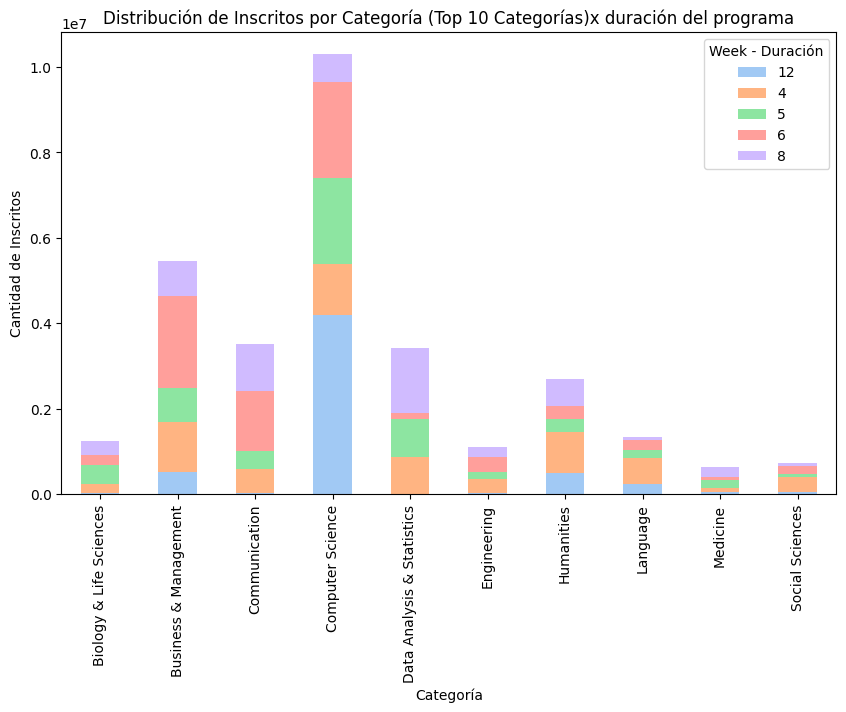

In [242]:
# Filtrar el DataFrame por las categorías con mayor número de inscritos
df_top_categorias = df_edx[df_edx['subject'].isin(top_10_categorias)]

# Obtener las 5 duraciones con mayor número de inscritos
df_top_course_length = df_top_categorias.groupby('course_length')['n_enrolled'].sum().nlargest(5).index

# Filtrar el DataFrame por las duraciones con mayor número de inscritos
df_top_course_length = df_top_categorias[df_top_categorias['course_length'].isin(df_top_course_length)]

# Calcular la distribución de inscritos por categoría y duración
inscritos_por_categoria_course_length = df_top_course_length.groupby(['subject', 'course_length'])['n_enrolled'].sum().unstack()

# Crear un gráfico de barras apiladas
inscritos_por_categoria_course_length.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y los ejes
plt.title('Distribución de Inscritos por Categoría (Top 10 Categorías)x duración del programa')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Inscritos')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Mostrar la leyenda
plt.legend(title='Week - Duración')

# Mostrar el gráfico
plt.show()


Si comparamos la oferta que actualmente tenemos en la plataforma y la comparamos con la demanda actual en base a las categorias con mayor registro. Vemos un comportamiento adecuado. Asimismo, observamos que podemos seguir creciendo en cursos de 12 meses en la categoria Data Science.



In [243]:
# Obtener los idiomas únicos presentes en el DataFrame
idiomas_unicos = df_edx['language'].unique()

# Crear un diccionario para almacenar el recuento de inscritos por idioma
recuento_inscritos_idioma = {}

# Calcular el recuento de inscritos para cada idioma
for idioma in idiomas_unicos:
    # Filtrar el DataFrame por el idioma actual
    df_idioma = df_edx[df_edx['language'] == idioma]

    # Calcular el recuento total de inscritos para el idioma actual
    total_inscritos = df_idioma['n_enrolled'].sum()

    # Almacenar el recuento en el diccionario
    recuento_inscritos_idioma[idioma] = total_inscritos

# Convertir el diccionario en una serie para facilitar la visualización
serie_inscritos_idioma = pd.Series(recuento_inscritos_idioma)

# Ordenar la serie por el número de inscritos de mayor a menor
serie_inscritos_idioma = serie_inscritos_idioma.sort_values(ascending=False)

print (serie_inscritos_idioma)

English          4.537295e+07
Español          5.249952e+06
Italiano         2.815850e+05
Français         2.019432e+05
Português        9.249061e+04
中文               8.438920e+04
日本語              6.275700e+04
اللغة العربية    3.937989e+04
Deutsch          1.065700e+04
dtype: float64


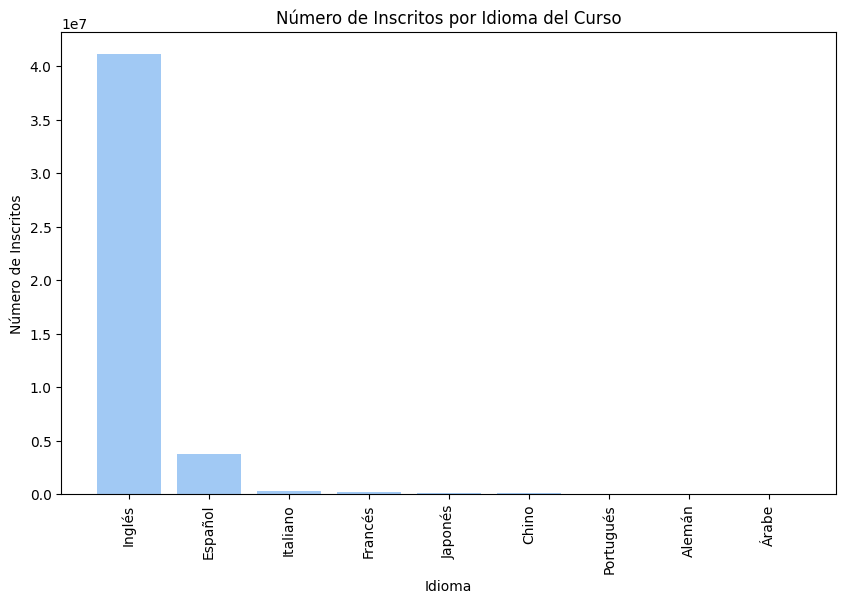

In [244]:
idiomas = ['Inglés', 'Español', 'Italiano', 'Francés', 'Japonés', 'Chino', 'Portugués', 'Alemán', 'Árabe']
inscritos = [41118308, 3704975, 281585, 161848, 62757, 56158, 44021, 10657, 0]

plt.figure(figsize=(10, 6))
plt.bar(idiomas, inscritos)

plt.title('Número de Inscritos por Idioma del Curso')
plt.xlabel('Idioma')
plt.ylabel('Número de Inscritos')

plt.xticks(rotation=90)

plt.show()



Los cursos que se encuentran en idioma ingles son los mas demandados por el publico. Seguido por idioma Español. Esto nos puedo hablar de la nacionalidad de nuestros consumidores. Los cuales del idioma ingles que es universal tenemos los de habla hispanosparlantes.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


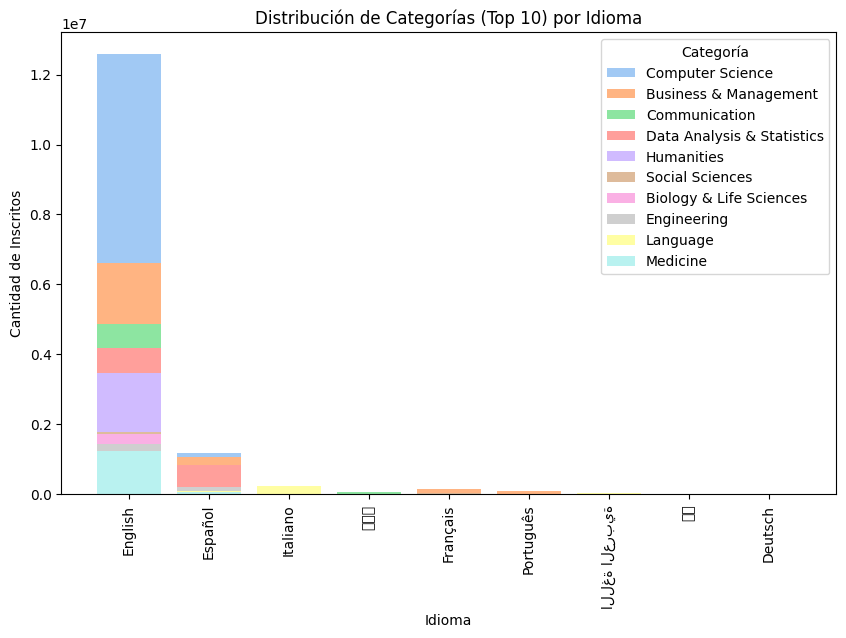

In [245]:
import numpy as np

# Obtener las categorías (top 10) con mayor número de inscritos
top_10_categorias = df_edx.groupby('subject')['n_enrolled'].sum().nlargest(10).index

# Filtrar el DataFrame por las categorías (top 10)
df_top_categorias = df_edx[df_edx['subject'].isin(top_10_categorias)]

# Obtener los idiomas únicos
idiomas = df_top_categorias['language'].unique()

# Crear una matriz de datos para las categorías y los idiomas
datos = np.zeros((len(top_10_categorias), len(idiomas)))

for i, categoria in enumerate(top_10_categorias):
    df_categoria = df_top_categorias[df_top_categorias['subject'] == categoria]
    inscritos_por_idioma = df_categoria.groupby('language')['n_enrolled'].sum()
    datos[i] = [inscritos_por_idioma.get(idioma, 0) for idioma in idiomas]

# Crear un gráfico de barras apiladas
plt.figure(figsize=(10, 6))

for i in range(len(top_10_categorias)):
    plt.bar(idiomas, datos[i], label=top_10_categorias[i])

plt.title('Distribución de Categorías (Top 10) por Idioma')
plt.xlabel('Idioma')
plt.ylabel('Cantidad de Inscritos')

plt.xticks(rotation=90)

plt.legend(title='Categoría')

plt.show()


Las categoria DataScience es la que en su mayoria se encuentra en idioma ingles. Encontramos un espacio de crecimiento de los cursos de DataScience en idioma español.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

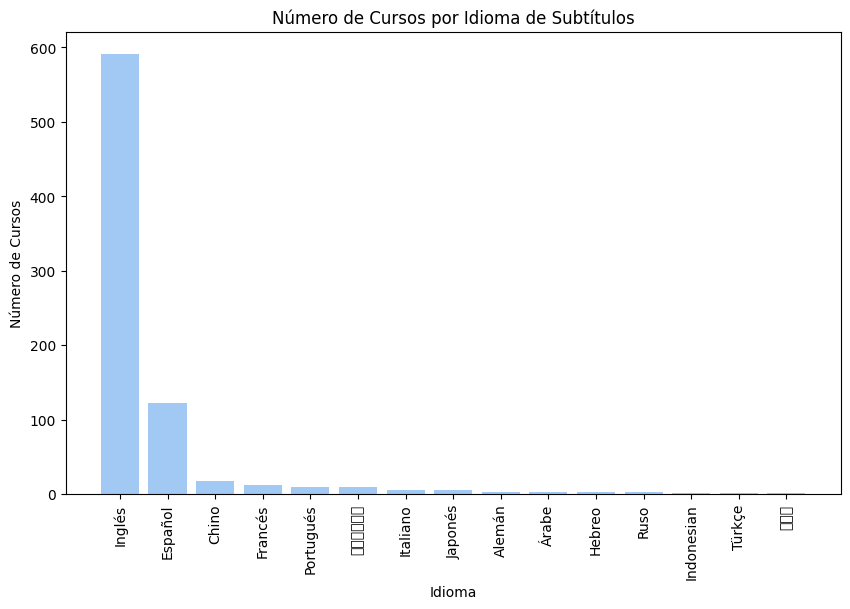

In [246]:
# Importar la biblioteca matplotlib.pyplot
import matplotlib.pyplot as plt

# Obtener las top 10 categorías más votadas basadas en "n-enrolled" y "subject"
top_categorias = df_edx.groupby('subject')['n_enrolled'].sum().nlargest(10).index.tolist()

# Filtrar el DataFrame original para incluir solo las categorías más votadas
df_filtrado = df_edx[df_edx['subject'].isin(top_categorias)]

# Crear un diccionario para contar la frecuencia de cada subtitulo individual
idiomas_individuales = {}

# Iterar sobre las entradas de idiomas
for idioma in df_filtrado['subtitles']:
    # Verificar si el idioma es una cadena válida
    if isinstance(idioma, str):
        # Dividir los idiomas separados por comas
        idiomas_separados = idioma.split(',')

        # Iterar sobre los idiomas separados
        for idioma_separado in idiomas_separados:
            # Eliminar espacios en blanco
            idioma_separado = idioma_separado.strip()

            # Contar la frecuencia del idioma individual
            if idioma_separado in idiomas_individuales:
                idiomas_individuales[idioma_separado] += 1
            else:
                idiomas_individuales[idioma_separado] = 1

# Obtener los idiomas y la frecuencia de cada uno
idiomas_ordenados = sorted(idiomas_individuales.keys(), key=lambda x: idiomas_individuales[x], reverse=True)
cursos_por_idioma = [idiomas_individuales[idioma] for idioma in idiomas_ordenados]

# Mapear los nombres de los idiomas al español
def mapear_idioma(idioma):
    if idioma == 'English':
        return 'Inglés'
    elif idioma == 'Español':
        return 'Español'
    elif idioma == 'Italiano':
        return 'Italiano'
    elif idioma == 'Français':
        return 'Francés'
    elif idioma == '日本語':
        return 'Japonés'
    elif idioma == '中文':
        return 'Chino'
    elif idioma == 'Português':
        return 'Portugués'
    elif idioma == 'Deutsch':
        return 'Alemán'
    elif idioma == 'עברית':
        return 'Hebreo'
    elif idioma == 'Русский':
        return 'Ruso'
    elif idioma == 'اللغة العربية':
        return 'Árabe'
    else:
        return idioma

idiomas_espanol = [mapear_idioma(idioma) for idioma in idiomas_ordenados]

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(idiomas_espanol, cursos_por_idioma)

plt.title('Número de Cursos por Idioma de Subtítulos')
plt.xlabel('Idioma')
plt.ylabel('Número de Cursos')

plt.xticks(rotation=90)

plt.show()


Observamos que la mayoria de los cursos en que cuantan con un numero alto de inscriptos es el idioma Ingles, seguido pr el Español. Lo cual es concordante con la eleccion del idioma.

In [247]:
df_udemy= pd.read_csv("udemy_courses.csv", sep=",", encoding = "utf-8")

In [248]:
df_udemy = df_udemy.drop_duplicates()  #eliminamos columnas repetidas

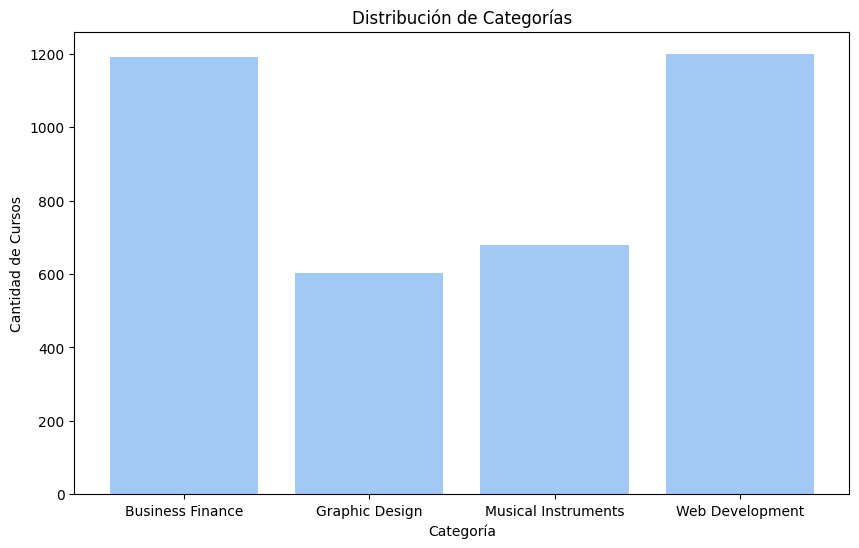

In [250]:
# Obtener los nombres únicos de las categorías
categorias = df_udemy['subject'].unique()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(categorias, [len(df_udemy[df_udemy['subject'] == categoria]) for categoria in categorias])

# Configurar el título y los ejes
plt.title('Distribución de Categorías')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Cursos')

# Mostrar el gráfico de barras
plt.show()


Observamos que la mayoria de los cursos ofrecidos en la plataforma se canaliza en Web Development y Business Finance

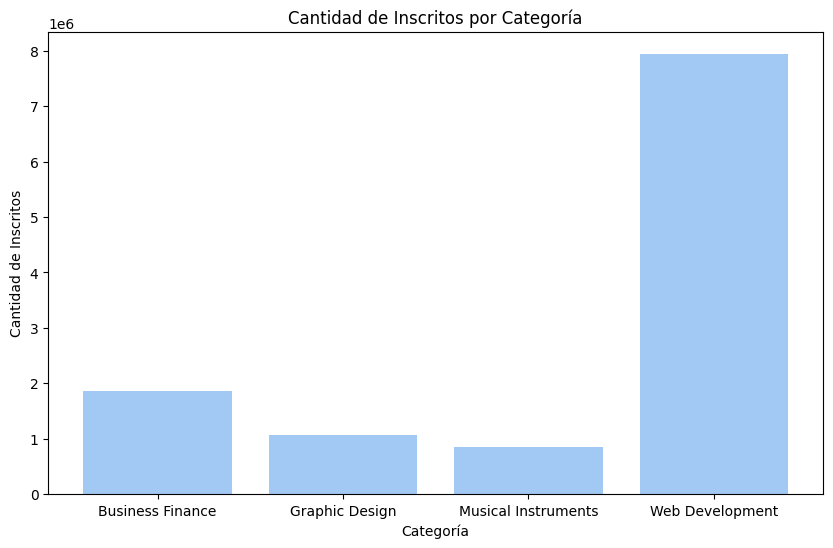

In [251]:
# Obtener las categorías y la cantidad de inscritos
categorias = df_udemy['subject'].unique()
cantidad_inscritos = df_udemy.groupby('subject')['num_subscribers'].sum().values

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(categorias, cantidad_inscritos)

# Configurar el título y los ejes
plt.title('Cantidad de Inscritos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Inscritos')

# Mostrar el gráfico de barras
plt.show()


Observamos que la mayor cantidad de inscriptos se canaliza en web Development y Business Finance

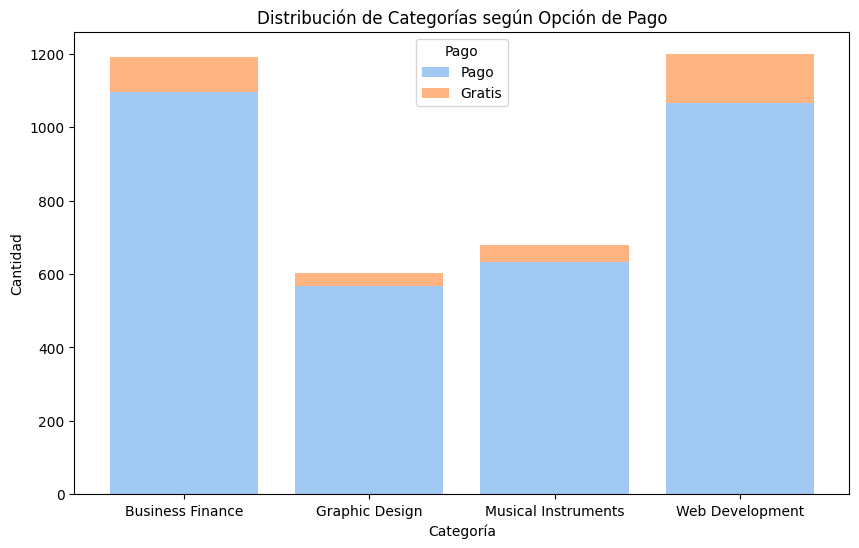

In [252]:
# Filtrar el DataFrame por las dos opciones de pago
df_udemy_paid = df_udemy[df_udemy['is_paid'] == True]
df_udemy_free = df_udemy[df_udemy['is_paid'] == False]

# Obtener las categorías y contar su frecuencia en cada opción de pago
categorias = df_udemy['subject'].unique()
count_paid = df_udemy_paid.groupby('subject').size().values
count_free = df_udemy_free.groupby('subject').size().values

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
plt.bar(categorias, count_paid, label='Pago')
plt.bar(categorias, count_free, bottom=count_paid, label='Gratis')

# Configurar el título y los ejes
plt.title('Distribución de Categorías según Opción de Pago')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')

# Mostrar la leyenda
plt.legend(title='Pago')

# Mostrar el gráfico de barras apiladas
plt.show()

Observamos que las categorias mas demandas (Web Development como Business Finance) son las que poseen una mayor presencia de cursos pagos. Este un insight para considerar aumentar el precio de los cursos mas demandados. 

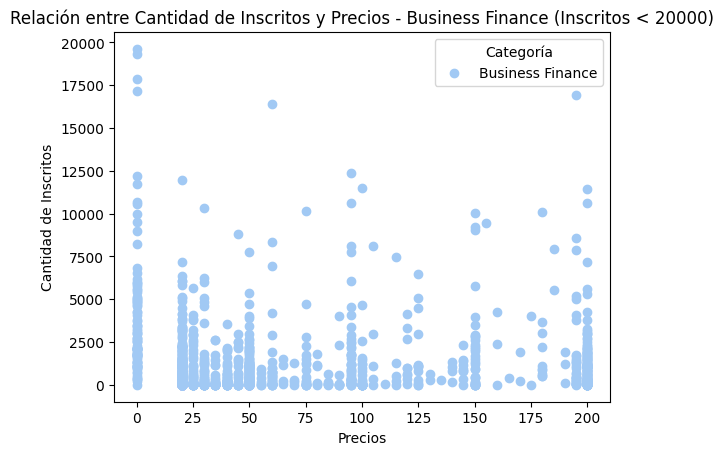

In [253]:
import matplotlib.pyplot as plt

# Filtrar los datos por la categoría 'Business Finance' y cantidad de alumnos inscritos menor a 20000
datos_categoria = df_udemy[(df_udemy['subject'] == 'Business Finance') & (df_udemy['num_subscribers'] < 20000)]

# Obtener la cantidad de alumnos inscritos y los precios
alumnos_inscritos = datos_categoria['num_subscribers']
precios = datos_categoria['price']

# Crear el gráfico de dispersión para la categoría 'Business Finance' con alumnos inscritos <  20000
plt.scatter( precios,alumnos_inscritos, label='Business Finance')

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscritos y Precios - Business Finance (Inscritos < 20000)')
plt.ylabel('Cantidad de Inscritos')
plt.xlabel('Precios')

# Agregar una leyenda
plt.legend(title='Categoría')

# Mostrar el gráfico
plt.show()


No podemos confirmar que el precio se un determinante para aumentar o reducir el número de inscriptos en la categoria de Negocios y Finanzas


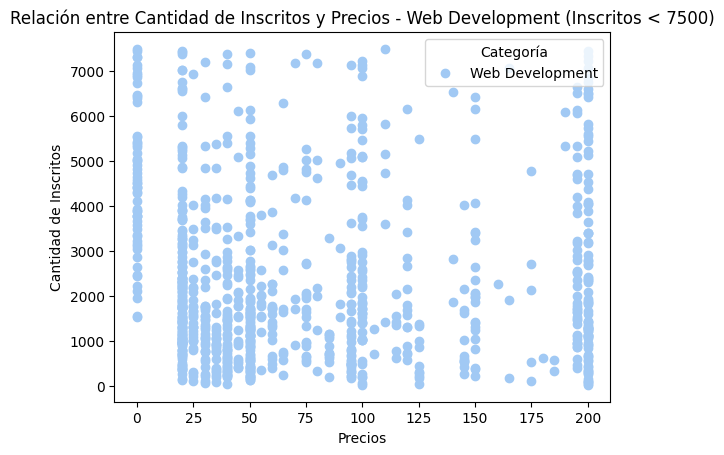

In [254]:
import matplotlib.pyplot as plt

# Filtrar los datos por la categoría 'Web Development' y cantidad de alumnos inscritos menor a 7500
datos_categoria = df_udemy[(df_udemy['subject'] == 'Web Development') & (df_udemy['num_subscribers'] < 7500)]

# Obtener la cantidad de alumnos inscritos y los precios
alumnos_inscritos = datos_categoria['num_subscribers']
precios = datos_categoria['price']

# Crear el gráfico de dispersión para la categoría 'Business Finance' con alumnos inscritos < 7500
plt.scatter( precios,alumnos_inscritos, label='Web Development')

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscritos y Precios - Web Development (Inscritos < 7500)')
plt.ylabel('Cantidad de Inscritos')
plt.xlabel('Precios')

# Agregar una leyenda
plt.legend(title='Categoría')

# Mostrar el gráfico
plt.show()

No podemos confirmar que el precio se un determinante para aumentar o reducir el numero de inscriptos en la categoria de Web Development. Dado que vemos cursos con precios elevados de esta categoria que posee precios elevados e igual retiene un numero elevado de inscriptos. Se destaca que se filtra a menor a 20.000 para eliminar cursos que son valores extremos de inscriptos.


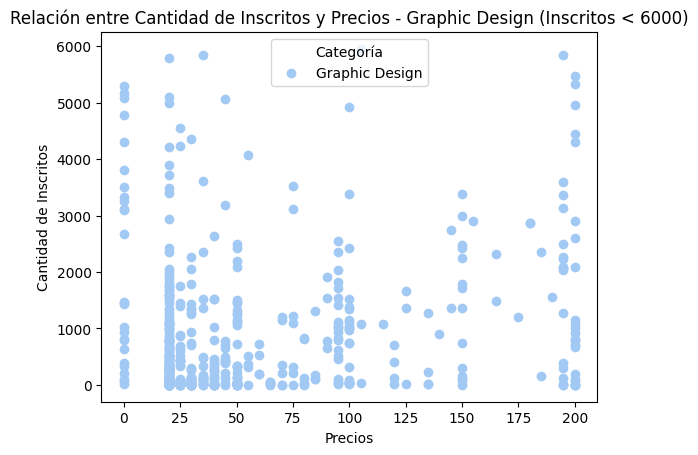

In [255]:
import matplotlib.pyplot as plt

# Filtrar los datos por la categoría 'Graphic Design' y cantidad de alumnos inscritos menor a 6000
datos_categoria = df_udemy[(df_udemy['subject'] == 'Graphic Design') & (df_udemy['num_subscribers'] < 6000)]

# Obtener la cantidad de alumnos inscritos y los precios
alumnos_inscritos = datos_categoria['num_subscribers']
precios = datos_categoria['price']

# Crear el gráfico de dispersión para la categoría 'Graphic Design' con alumnos inscritos < 6000
plt.scatter( precios,alumnos_inscritos, label='Graphic Design')

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscritos y Precios - Graphic Design (Inscritos < 6000)')
plt.ylabel('Cantidad de Inscritos')
plt.xlabel('Precios')

# Agregar una leyenda
plt.legend(title='Categoría')

# Mostrar el gráfico
plt.show()

Observamos que tanpoco hay una relacion directa o indirecta entre el auemnto del precio y la caida de la cantidad de inscriptos.

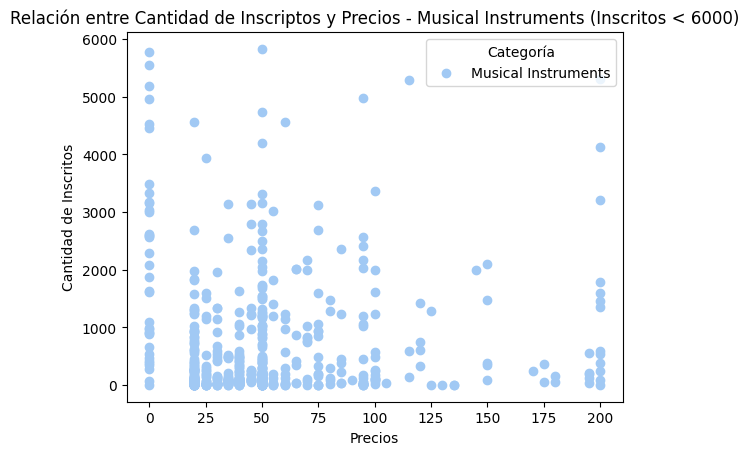

In [256]:
import matplotlib.pyplot as plt

# Filtrar los datos por la categoría 'Musical Instruments' y cantidad de alumnos inscritos menor a 6000
datos_categoria = df_udemy[(df_udemy['subject'] == 'Musical Instruments') & (df_udemy['num_subscribers'] < 6000)]

# Obtener la cantidad de alumnos inscritos y los precios
alumnos_inscritos = datos_categoria['num_subscribers']
precios = datos_categoria['price']

# Crear el gráfico de dispersión para la categoría 'Musical Instruments' con alumnos inscritos < 6000
plt.scatter( precios,alumnos_inscritos, label='Musical Instruments')

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscriptos y Precios - Musical Instruments (Inscritos < 6000)')
plt.ylabel('Cantidad de Inscritos')
plt.xlabel('Precios')

# Agregar una leyenda
plt.legend(title='Categoría')

# Mostrar el gráfico
plt.show()

Observamos que tanpoco hay una relacion directa o indirecta entre el auemnto del precio y la caida de la cantidad de inscriptos. Sin embargo observamos que concentran una mayor cantidad de alumnos en los precios menores a 100

In [257]:
niveles_unicos = df_udemy['level'].unique()
print(niveles_unicos)


['All Levels' 'Intermediate Level' 'Beginner Level' 'Expert Level']


In [258]:
reemplazos = {
    'Intermediate Level': 'Intermediate',
    'Beginner Level': 'Introductory',
    'Expert Level': 'Advanced'
}

df_udemy['level'] = df_udemy['level'].replace(reemplazos)


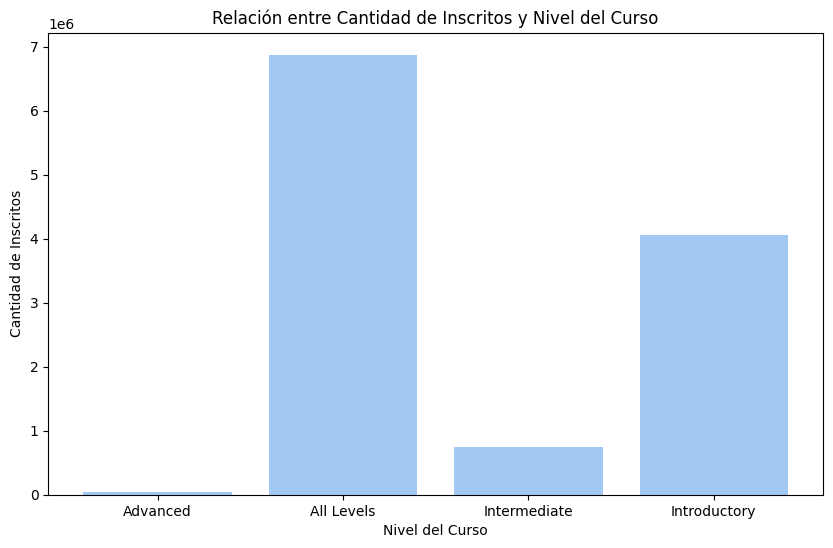

In [259]:
# Calcular la suma de inscritos por nivel
inscritos_por_nivel = df_udemy.groupby('level')['num_subscribers'].sum()

# Obtener los nombres de los niveles
niveles = inscritos_por_nivel.index

# Obtener la cantidad de inscritos por nivel
cantidad_inscritos = inscritos_por_nivel.values

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(niveles, cantidad_inscritos)

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscritos y Nivel del Curso')
plt.xlabel('Nivel del Curso')
plt.ylabel('Cantidad de Inscritos')

# Mostrar el gráfico de barras
plt.show()

Obsevamos que la mayoria de los cursos se encuentra en la categoria All Levels. Se mantiene respecto del competidor elx que posee una amplia cantidad de inscriptos en el curso introductorio.

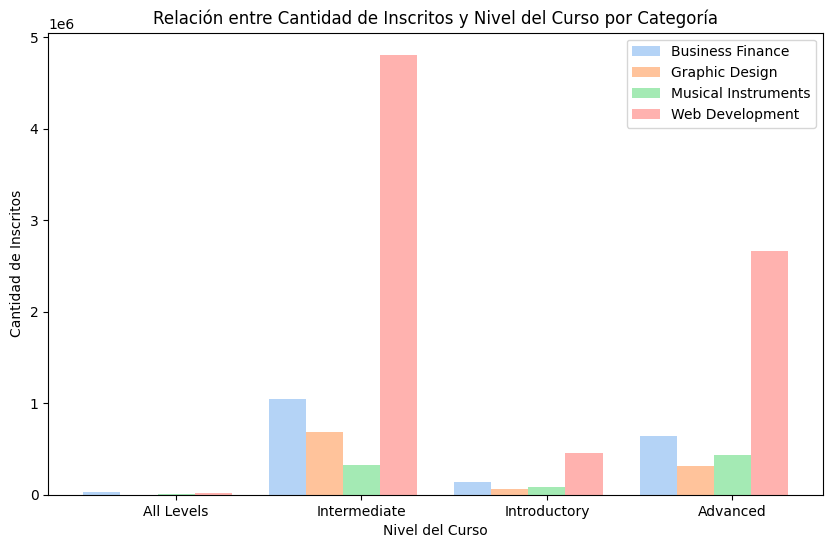

In [260]:
# Agrupar los datos por nivel y categoría, y calcular la suma de inscritos
inscritos_por_nivel_categoria = df_udemy.groupby(['level', 'subject'])['num_subscribers'].sum()

# Obtener los niveles y categorías únicas
niveles = df_udemy['level'].unique()
categorias = df_udemy['subject'].unique()

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
bar_width = 0.2
opacity = 0.8
offset = 0

for categoria in categorias:
    inscritos = inscritos_por_nivel_categoria.loc[:, categoria]
    plt.bar(np.arange(len(niveles)) + offset, inscritos, bar_width, alpha=opacity, label=categoria)
    offset += bar_width

# Configurar el título y los ejes
plt.title('Relación entre Cantidad de Inscritos y Nivel del Curso por Categoría')
plt.xlabel('Nivel del Curso')
plt.ylabel('Cantidad de Inscritos')

# Configurar las etiquetas del eje x
plt.xticks(np.arange(len(niveles)) + (len(categorias) * bar_width) / 2, niveles)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico de barras agrupadas
plt.show()


Se mantiene el criterio que las categorias vinculadas al rubro tecnologico tienen un amplia demanda de servicios Avanzados.

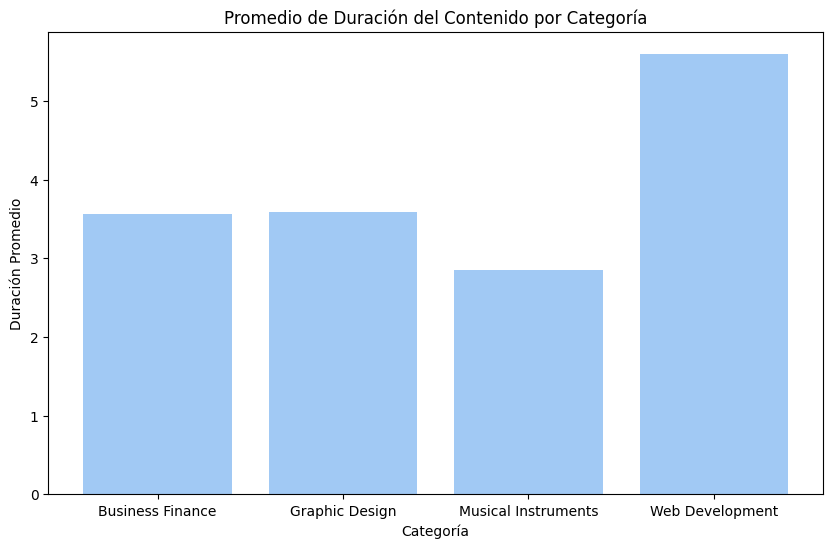

In [262]:
# Calcular el promedio de la duración del contenido por categoría
promedio_duracion = df_udemy.groupby('subject')['content_duration'].mean()

# Obtener las categorías y los promedios de duración
categorias = promedio_duracion.index
promedios = promedio_duracion.values

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(categorias, promedios)

# Configurar el título y los ejes
plt.title('Promedio de Duración del Contenido por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Duración Promedio')

# Mostrar el gráfico de barras
plt.show()


La duracion promedio de horas por categoria nos demuestra nos confirma que al igual que en los otros competidores las categorias vinculadas al rubro tecnologia, los alumnos estan dispuestos a consumir videos de mayor duracion.

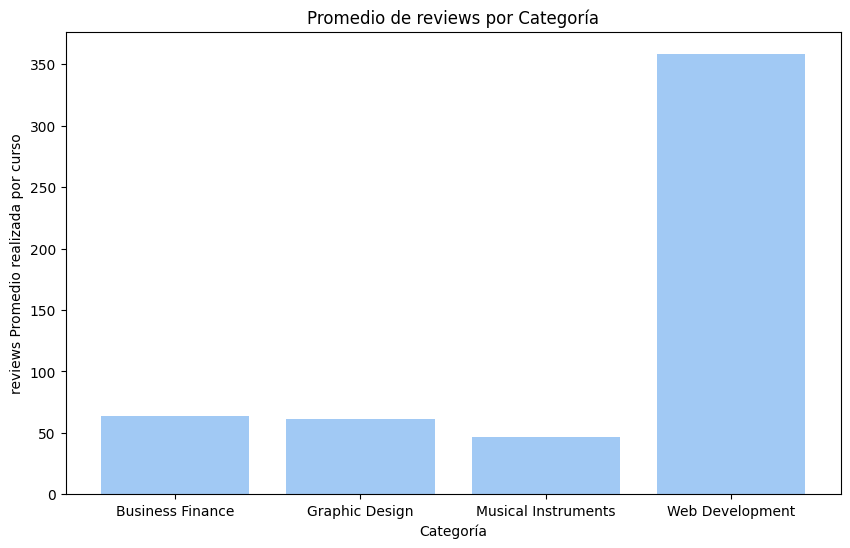

In [263]:
# Calcular el promedio de la reviews del contenido por categoría
promedio_reviews = df_udemy.groupby('subject')['num_reviews'].mean()

# Obtener las categorías y los promedios de reviews
categorias = promedio_reviews.index
promedios = promedio_reviews.values

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(categorias, promedios)

# Configurar el título y los ejes
plt.title('Promedio de reviews por Categoría')
plt.xlabel('Categoría')
plt.ylabel('reviews Promedio realizada por curso')

# Mostrar el gráfico de barras
plt.show()

Observamos que la categoria que posee mas retroalimentacion de los usuarios es la categoria Web Development. Lo cual es coincidente y esperable teniendo en cuenta la cantidad de personas que realizaron los cursos de esta categoria. Lo interesante es hacer una comparacion entre los inscriptos y aquellos que realizan el curso.

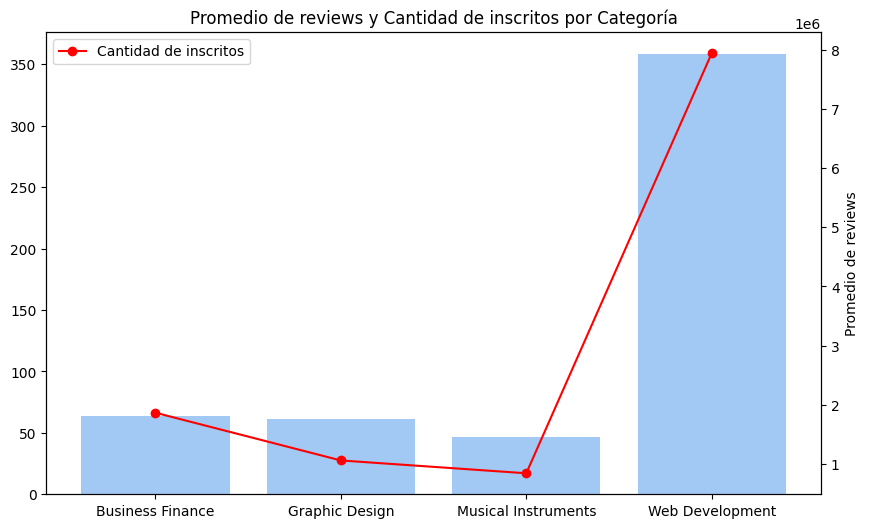

In [264]:
# Calcular el promedio de reviews y la suma de inscritos por categoría
promedio_reviews = df_udemy.groupby('subject')['num_reviews'].mean()
suma_inscritos = df_udemy.groupby('subject')['num_subscribers'].sum()

# Obtener las categorías, promedios de reviews y sumas de inscritos
categorias = promedio_reviews.index
promedios_reviews = promedio_reviews.values
sumas_inscritos = suma_inscritos.values

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))

# Configurar los ejes y la barra de promedios de reviews
plt.bar(categorias, promedios_reviews, label='Promedio de reviews')

# Configurar la barra de sumas de inscritos al lado derecho
ax = plt.gca().twinx()
ax.plot(categorias, sumas_inscritos, color='red', marker='o', linestyle='-', label='Cantidad de inscritos')
ax.set_ylabel('Cantidad de Inscritos')

# Configurar el título y las etiquetas de los ejes
plt.title('Promedio de reviews y Cantidad de inscritos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Promedio de reviews')

# Mostrar las leyendas
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.show()


Comparando con la cantidad de inscriptos por categoria,observamos que tenemos una buena respuesta de comentarios y review del publico que realiza a la plataforma. En el caso de Graphic Design y Musical Instruments observamos que se dejan mas reseñas que la media de inscriptos. Mientras que Web Development y Business Finance las reseñas son analogas al promedio de inscriptos por categoria.

Se nos solicita un Word Cloud de las palabras clave que más se repiten dentro del título -se pueden añadir otras variables de nuestro interés-.

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Economia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [2]:
df= pd.read_csv(r"C:/Users/Economia/Documents/Soy Henry/Proyecto Individual/Proyecto 2/Proyecto individual 2/Coursera_courses.csv", sep=",", encoding = "utf-8")

In [4]:
df = df.drop_duplicates()  #eliminamos columnas repetidas

In [5]:
df1= pd.read_csv(r"C:/Users/Economia/Documents/Soy Henry/Proyecto Individual/Proyecto 2/Proyecto individual 2/edx_courses.csv", sep=",", encoding = "utf-8")

In [6]:
df1 = df1.drop_duplicates()  #eliminamos columnas repetidas

In [7]:
df2= pd.read_csv(r"C:/Users/Economia/Documents/Soy Henry/Proyecto Individual/Proyecto 2/Proyecto individual 2/udemy_courses.csv", sep=",", encoding = "utf-8")

In [8]:
df2 = df2.drop_duplicates()

In [11]:
df_titulos = df.copy()
df_titulos = df_titulos[['name']]

In [23]:
df_titulos.columns

Index(['title'], dtype='object')

In [12]:
df_titulos1 = df1.copy()
df_titulos1 = df_titulos1[['title']]

In [22]:
df_titulos1.columns

Index(['title'], dtype='object')

In [14]:
df_titulos2 = df2.copy()
df_titulos2 = df_titulos2[['course_title']]

In [17]:
df_titulos.rename(columns={'name': 'title'}, inplace=True)

In [18]:
df_titulos2.rename(columns={'course_title': 'title'}, inplace=True)

In [28]:
columna_title_df1 = df_titulos['title'].tolist()
columna_title_df2 = df_titulos1['title'].tolist()
columna_title_df3 = df_titulos2['title'].tolist()

lista_combinada = columna_title_df1 + columna_title_df2 + columna_title_df3


In [30]:
text = " ".join(lista_combinada)

In [31]:
from nltk.tokenize import word_tokenize

token= word_tokenize(text)

In [32]:
len(token)

37798

In [33]:
import string
token2=[]

for word in token:
  for letter in word:
    if letter in string.punctuation: 
      word=word.replace(letter,"") 
  token2.append(word)

print(token2)

['Machine', 'Learning', 'Indigenous', 'Canada', 'The', 'Science', 'of', 'WellBeing', 'Technical', 'Support', 'Fundamentals', 'Become', 'a', 'CBRS', 'Certified', 'Professional', 'Installer', 'by', 'Google', 'Financial', 'Markets', 'Introduction', 'to', 'Psychology', 'Programming', 'for', 'Everybody', '', 'Getting', 'Started', 'with', 'Python', '', 'The', 'Bits', 'and', 'Bytes', 'of', 'Computer', 'Networking', 'AI', 'For', 'Everyone', 'Crash', 'Course', 'on', 'Python', 'Psychological', 'First', 'Aid', 'Neural', 'Networks', 'and', 'Deep', 'Learning', 'What', 'is', 'Data', 'Science', '', 'Successful', 'Negotiation', '', 'Essential', 'Strategies', 'and', 'Skills', 'Fundamentals', 'of', 'Project', 'Planning', 'and', 'Management', 'Project', 'Launch', 'Brand', 'Management', '', 'Aligning', 'Business', '', 'Brand', 'and', 'Behaviour', 'Writing', 'in', 'the', 'Sciences', 'Stanford', 'Introduction', 'to', 'Food', 'and', 'Health', 'HTML', '', 'CSS', '', 'and', 'Javascript', 'for', 'Web', 'Develop

In [34]:
len(token2)

37798

In [35]:
token3 =[]

for word in token2:
  if word != "":
    token3.append(word)

print(token3)

['Machine', 'Learning', 'Indigenous', 'Canada', 'The', 'Science', 'of', 'WellBeing', 'Technical', 'Support', 'Fundamentals', 'Become', 'a', 'CBRS', 'Certified', 'Professional', 'Installer', 'by', 'Google', 'Financial', 'Markets', 'Introduction', 'to', 'Psychology', 'Programming', 'for', 'Everybody', 'Getting', 'Started', 'with', 'Python', 'The', 'Bits', 'and', 'Bytes', 'of', 'Computer', 'Networking', 'AI', 'For', 'Everyone', 'Crash', 'Course', 'on', 'Python', 'Psychological', 'First', 'Aid', 'Neural', 'Networks', 'and', 'Deep', 'Learning', 'What', 'is', 'Data', 'Science', 'Successful', 'Negotiation', 'Essential', 'Strategies', 'and', 'Skills', 'Fundamentals', 'of', 'Project', 'Planning', 'and', 'Management', 'Project', 'Launch', 'Brand', 'Management', 'Aligning', 'Business', 'Brand', 'and', 'Behaviour', 'Writing', 'in', 'the', 'Sciences', 'Stanford', 'Introduction', 'to', 'Food', 'and', 'Health', 'HTML', 'CSS', 'and', 'Javascript', 'for', 'Web', 'Developers', 'Excel', 'Skills', 'for', 

In [36]:
len(token3)

34031

In [37]:
token4 =[]

for word in token3:
  word = word.lower()
  token4.append(word)

print(token4)

['machine', 'learning', 'indigenous', 'canada', 'the', 'science', 'of', 'wellbeing', 'technical', 'support', 'fundamentals', 'become', 'a', 'cbrs', 'certified', 'professional', 'installer', 'by', 'google', 'financial', 'markets', 'introduction', 'to', 'psychology', 'programming', 'for', 'everybody', 'getting', 'started', 'with', 'python', 'the', 'bits', 'and', 'bytes', 'of', 'computer', 'networking', 'ai', 'for', 'everyone', 'crash', 'course', 'on', 'python', 'psychological', 'first', 'aid', 'neural', 'networks', 'and', 'deep', 'learning', 'what', 'is', 'data', 'science', 'successful', 'negotiation', 'essential', 'strategies', 'and', 'skills', 'fundamentals', 'of', 'project', 'planning', 'and', 'management', 'project', 'launch', 'brand', 'management', 'aligning', 'business', 'brand', 'and', 'behaviour', 'writing', 'in', 'the', 'sciences', 'stanford', 'introduction', 'to', 'food', 'and', 'health', 'html', 'css', 'and', 'javascript', 'for', 'web', 'developers', 'excel', 'skills', 'for', 

In [38]:
len(token4)

34031

In [40]:
token5 =[]

for word in token4:
  if len(word)>=4:
    token5.append(word)

print(token5)

['machine', 'learning', 'indigenous', 'canada', 'science', 'wellbeing', 'technical', 'support', 'fundamentals', 'become', 'cbrs', 'certified', 'professional', 'installer', 'google', 'financial', 'markets', 'introduction', 'psychology', 'programming', 'everybody', 'getting', 'started', 'with', 'python', 'bits', 'bytes', 'computer', 'networking', 'everyone', 'crash', 'course', 'python', 'psychological', 'first', 'neural', 'networks', 'deep', 'learning', 'what', 'data', 'science', 'successful', 'negotiation', 'essential', 'strategies', 'skills', 'fundamentals', 'project', 'planning', 'management', 'project', 'launch', 'brand', 'management', 'aligning', 'business', 'brand', 'behaviour', 'writing', 'sciences', 'stanford', 'introduction', 'food', 'health', 'html', 'javascript', 'developers', 'excel', 'skills', 'business', 'essentials', 'introduction', 'negotiation', 'strategic', 'playbook', 'becoming', 'principled', 'persuasive', 'negotiator', 'everyday', 'excel', 'part', 'learning', 'learn'

In [41]:
len(token5)


24580

Stopwords

In [42]:
from nltk.corpus import stopwords

nltk.download("stopwords")

a=set(stopwords.words('spanish'))

token6 = [word for word in token5 if word not in a]

print(a)
print(token6)

{'otras', 'nuestra', 'que', 'habremos', 'tengas', 'e', 'algo', 'las', 'has', 'por', 'nosotras', 'este', 'ellas', 'estarían', 'tiene', 'estarán', 'somos', 'todos', 'estas', 'sus', 'hubieron', 'tenidos', 'y', 'esas', 'tuvieras', 'estoy', 'tuviera', 'habríais', 'tuvo', 'cuando', 'seas', 'fueras', 'estaba', 'estuvieses', 'fuerais', 'tus', 'antes', 'ti', 'habiendo', 'estarás', 'seremos', 'quien', 'míos', 'suyo', 'serías', 'tuviste', 'cual', 'estuvieran', 'tuvieran', 'estadas', 'habré', 'suyas', 'tenéis', 'estar', 'teniendo', 'sintiendo', 'hayas', 'estado', 'hubimos', 'mío', 'fuimos', 'nada', 'muchos', 'estuvieseis', 'estuvieras', 'había', 'hubiesen', 'hayamos', 'fueron', 'su', 'todo', 'habríamos', 'unos', 'nos', 'tendrá', 'hayan', 'siente', 'son', 'estuvieron', 'estaréis', 'durante', 'hubierais', 'serás', 'a', 'habíais', 'donde', 'estuviéramos', 'habían', 'te', 'habrías', 'estuviste', 'hubieras', 'o', 'sentidos', 'los', 'tendrías', 'en', 'mis', 'esto', 'estaríais', 'estéis', 'estarías', 'un

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Economia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
len(token6)

24468

In [44]:
from nltk.probability import FreqDist

fdist = FreqDist(token6)
fdist

FreqDist({'learn': 513, 'with': 451, 'trading': 317, 'beginners': 292, 'course': 260, 'introduction': 256, 'design': 247, 'from': 246, 'guitar': 224, 'your': 197, ...})

In [46]:
from PIL import Image

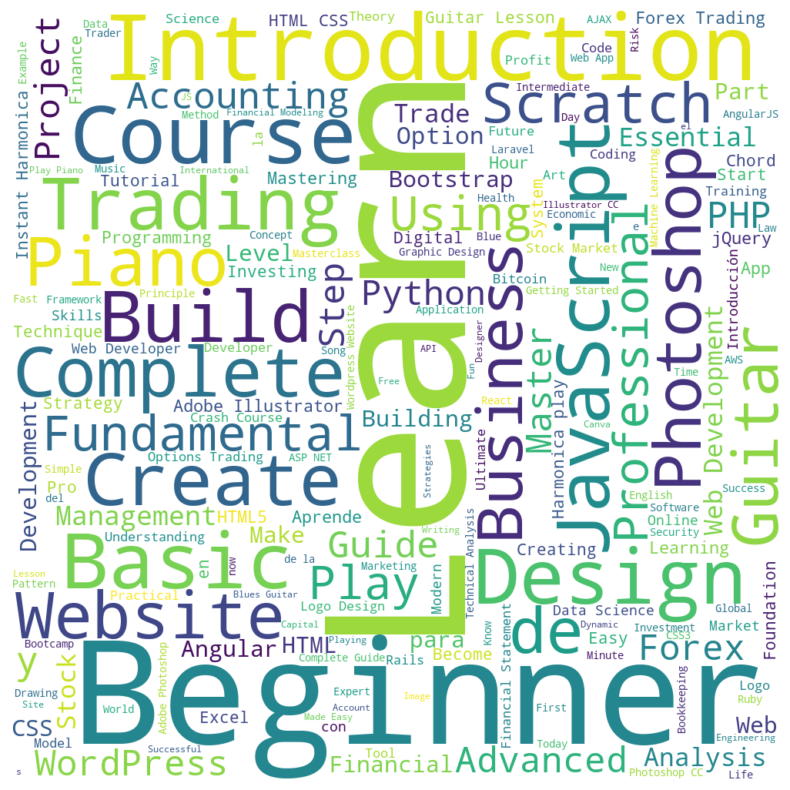

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenar todos los textos en una sola cadena
text = " ".join(lista_combinada)

# Crear la nube de palabras
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=8).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()
